In [1]:
import sys
print ( sys.path )

import numpy as np
import pandas as pd
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
from joblib import dump, load
import scipy.stats
plt.style.use(mplhep.style.CMS)
import matplotlib.font_manager
mpl.rcParams.update(
    {'font.size': 18,
     'font.family': 'sans-serif',
     'legend.fontsize': 14,
     'axes.labelsize': 18,
     'xtick.labelsize': 14,
     'ytick.labelsize': 14
    }
    )

['/cvmfs/sft.cern.ch/lcg/releases/condor/8.9.11-e1651/x86_64-centos7-gcc11-opt/lib/python3', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/itk', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python39.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/lib-dynload', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/IPython/extensions', '/scratch/malvesga/.ipyth

In [2]:
from processing import lumi_periods_2017, lumi_periods_2018

#lepton_type = 'muon'
lepton_type = 'electron'

# data_sample = '2017'
data_sample = '2018'

save_figures = False

{'muon': {'2017B': 4.799881474, '2017C1': 5.785813941, '2017C2': 3.786684323, '2017D': 4.247682053, '2017E': 9.312832062, '2017F1': 1.738905587, '2017F2': 8.125575961, '2017F3': 3.674404546}, 'electron': {'2017B': 4.594096155565198, '2017C1': 5.521298099245362, '2017C2': 3.6135646891210857, '2017D': 4.0518639103567, '2017E': 8.906848461089172, '2017F1': 1.6584516422062712, '2017F2': 7.749629938012412, '2017F3': 3.504400870870218}}
Luminosity 2017 muon: 41.471779946999995
Luminosity 2017 electron: 39.60015376646642
{'muon': {'2018A': 12.103512482, '2018B1': 6.3798061, '2018B2': 0.40141386, '2018C': 6.524227381, '2018D1': 19.877577, '2018D2': 10.414449}, 'electron': {'2018A': 12.103189833, '2018B1': 6.379806, '2018B2': 0.40141386, '2018C': 6.527251329, '2018D1': 19.876804, '2018D2': 10.414449}}
Luminosity 2018 muon: 55.700985822999996
Luminosity 2018 electron: 55.702914022


### Event selection

In [3]:
def tau21_ddt_calculation(df, lepton_type, label_jet=None):
    
    label_jet_ = "_nom"
    if label_jet is not None: label_jet_ = label_jet
        
    jet0_tau21_ = ( df.loc[ :, "jet0_tau2"] / df.loc[ :, "jet0_tau1"] )
    
    M_ = 0. ##M is the slope of the tau21 versus rhoprime1
    rhoprime1_ = np.log((((df.loc[ :, "jet0_corrmass" + label_jet_])**2)/(df.loc[ :, "jet0_pt" + label_jet_])))
    if lepton_type == 'muon':
        #M_ = -0.06549078537121121 
        M_ = -0.06985584011450555
    if lepton_type == 'electron':
        #M_ = -0.05984253738963618    
        M_ = -0.057877831836395534    
    jet0_tau21_ddt_ = jet0_tau21_ - (M_*rhoprime1_)
    
    return jet0_tau21_, rhoprime1_, jet0_tau21_ddt_

In [4]:
def select_events( df_events, lepton_type, max_num_tracks = -1, label_jet=None, label_muon=None, label_electron=None ):

    max_num_tracks_ = max_num_tracks
    
#     label_jet_ = "_nom"
#     label_muon_ = "_nom"
#     label_WLep_ = "_nom"
#     label_WW_ = "_nom"
    label_jet_ = "_nom"
    if label_jet is not None: label_jet_ = label_jet
        
    label_muon_ = "_nom"
    if label_muon is not None: label_muon_ = label_muon
        
    label_electron_ = "_nom"
    if label_electron is not None: label_electron_ = label_electron
        
    label_WLep_ = "_nom"
    if label_muon is not None:
        label_WLep_ = label_muon
    elif label_electron is not None:
        label_WLep_ = label_electron
        
    label_WW_ = "_nom"
    if label_jet is not None:
        label_WW_ = label_jet
    elif label_muon is not None:
        label_WW_ = label_muon
    elif label_electron is not None:
        label_WW_ = label_electron
        
    label_xiCMS_ = "_nom"
    if label_jet is not None:
        label_xiCMS_ = label_jet
    elif label_muon is not None:
        label_xiCMS_ = label_muon
    elif label_electron is not None:
        label_xiCMS_ = label_electron
    
    lepton_var_pt_ = ""
    lepton_var_phi_ = ""
    lepton_var_eta_ = ""
    if lepton_type == 'muon':
        lepton_var_pt_ = "muon0_pt"
        lepton_var_phi_ = "muon0_phi"
        lepton_var_eta_ = "muon0_eta"
    elif lepton_type == 'electron':
        lepton_var_pt_ = "electron0_pt"
        lepton_var_phi_ = "electron0_phi"
        lepton_var_eta_ = "electron0_eta"
           
    deltaPhi_jet_lep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, lepton_var_phi_ ] )
    msk_dphi_ = ( deltaPhi_jet_lep_ < -np.pi )
    deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_lep_ >= np.pi )
    deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaEta_jet_lep_ = ( df_events.loc[ :, "jet0_eta"] - df_events.loc[ :, lepton_var_eta_ ] )
    deltaR_jet_lep_ = np.sqrt( ( deltaPhi_jet_lep_ ) ** 2 + ( deltaEta_jet_lep_ ) ** 2 )
    
    deltaPhi_jet_met_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "met_phi"] )
    msk_dphi_ = ( deltaPhi_jet_met_ < -np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_met_ >= np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaPhi_jet_Wlep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "WLeptonicPhi"] )
    msk_dphi_ = ( deltaPhi_jet_Wlep_ < -np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_Wlep_ >= np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] - 2*np.pi

    jet0_tau21_, rhoprime1_, jet0_tau21_ddt_ = tau21_ddt_calculation( df_events, lepton_type )

    msk_All_ = np.full( df_events.shape[0], True, dtype=bool )
    
    msk_lep_ = None
    if lepton_type == 'muon':
        msk_lep_ = ( ( df_events.loc[ :, "muon0_pt" + label_muon_ ] >= 50.0 ) &
                     ( np.abs( df_events.loc[ :, "muon0_eta"] ) <= 2.4 ) & 
                     ( df_events.loc[ :, "muon0_iso"] <= 0.10 ) )
    elif lepton_type == 'electron':
        msk_lep_ = ( ( df_events.loc[ :, "electron0_pt" + label_electron_ ] >= 50.0 ) &
                     ( np.abs( df_events.loc[ :, "electron0_eta"] ) <= 2.4 ) )
        
    msk_jet_ = ( ( df_events.loc[ :, "jet0_pt" + label_jet_] >= 220.0 ) &
                 ( np.abs( df_events.loc[ :, "jet0_eta"] ) <= 2.4 ) )
    
    msk_jet_lep_ = ( deltaR_jet_lep_ >= np.pi/2 )
    
    if lepton_type == 'muon':
        msk_met_ = ( df_events.loc[ :, "met"] >= 40.0 )
    elif lepton_type == 'electron':
        msk_met_ = ( df_events.loc[ :, "met"] >= 100.0 )  
    
    msk_jet_met_ = ( np.abs( deltaPhi_jet_met_ ) >= 2.0 )
    
    #msk_pruned_mass_ = ( ( df_events.loc[ :, "jet0_corrmass" + label_jet_] >= 0.0 ) &
    #                     ( df_events.loc[ :, "jet0_corrmass" + label_jet_] <= 200.0 ) )
    msk_pruned_mass_ = ( ( df_events.loc[ :, "jet0_corrmass" + label_jet_] >= 50.0 ) &
                         ( df_events.loc[ :, "jet0_corrmass" + label_jet_] <= 110.0 ) )
    
    msk_tau21_       = ( jet0_tau21_ddt_ <= 0.7 )
    #msk_tau21_       = ( jet0_tau21_ddt_ <= 1. )
    #msk_tau21_       = ( jet0_tau21_ <= 0.6 )
    
    msk_bjet_veto_   = ( df_events.loc[ :, "num_bjets_ak4"] == 0 )
    
    msk_xiCMS_       = ( ( df_events.loc[ :, "xiCMS_45" + label_xiCMS_ ] <= 0.20 ) & ( df_events.loc[ :, "xiCMS_56" + label_xiCMS_ ] <= 0.20 ) )
    
    msk_Wlep_ = ( df_events.loc[ :, "WLeptonicPt" + label_WLep_ ] >= 200.0 )
    
    msk_jet_Wlep_ = ( np.abs( deltaPhi_jet_Wlep_ ) >= 2.5 )
    
    msk_MWW_ = ( df_events.loc[ :, "MWW" + label_WW_ ] >= 500.0 )
    
    msk_extra_tracks_ = None
    if max_num_tracks_ >= 0:
        msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= max_num_tracks_ )
    else:
        msk_extra_tracks_ = np.full( df_events.shape[0], True, dtype=bool )
    
    ## HEM Failure
    
    msk_lep_eta_ = None
    msk_lep_phi_ = None
    msk_HEM_failure = None
    
    if lepton_type == 'electron':
        msk_lep_eta_ = ( df_events.loc[:,"electron0_eta"] >= -1.3 )   
        msk_lep_phi_ = ( ( df_events.loc[:,"electron0_phi"] <= -1.57 ) | ( df_events.loc[:,"electron0_phi"] >= -0.87 ) )
        msk_HEM_failure = msk_lep_eta_ & msk_lep_phi_
        
        
    masks_ = None
        
    if lepton_type == 'muon':
        masks_ = [ msk_All_, msk_lep_, msk_jet_, msk_jet_lep_, msk_met_, msk_jet_met_,
                   msk_pruned_mass_, msk_tau21_, msk_bjet_veto_, msk_xiCMS_,
                   msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_ ]
    elif lepton_type == 'electron':
        masks_ = [ msk_All_, msk_lep_, msk_jet_, msk_jet_lep_, msk_met_, msk_jet_met_,
                   msk_pruned_mass_, msk_tau21_, msk_bjet_veto_, msk_xiCMS_,
                   msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_, msk_HEM_failure ]
#     masks_ = [ msk_All_, msk_lep_, msk_jet_ ]
    
    lepton_sel_name_ = ""
    jet_lepton_sel_name_ = ""
    if lepton_type == 'muon':
        lepton_sel_name_ = "Muon"
        jet_lepton_sel_name_ = "Jet_Muon"
    elif lepton_type == 'electron':
        lepton_sel_name_ = "Electron"
        jet_lepton_sel_name_ = "Jet_Electron"
        
    selection_keys_ = None
        
    if lepton_type == 'muon':
        selection_keys_ = [ "All", lepton_sel_name_, "Jet", jet_lepton_sel_name_, "MET", "Jet_MET",
                            "PrunedMass", "Tau21", "BJet_Veto", "Xi_CMS",
                            "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks"]
    elif lepton_type == 'electron':
        selection_keys_ = [ "All", lepton_sel_name_, "Jet", jet_lepton_sel_name_, "MET", "Jet_MET",
                            "PrunedMass", "Tau21", "BJet_Veto", "Xi_CMS",
                            "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks", "HEM Failure" ]
#     selection_keys_ = [ "All", lepton_sel_name_, "Jet" ]
    
    selections_ = {}
    msk_ = masks_[ 0 ].copy()
    for idx_, key_ in enumerate( selection_keys_ ):
        msk_ = msk_ & masks_[ idx_ ]
        selections_[ key_ ] = np.sum( msk_ )
        
    df_events = df_events.loc[ msk_ ]
    
    return df_events, selection_keys_, selections_, deltaPhi_jet_lep_

### MC (Signal)

In [5]:
load_signal = True

labels_signals = []
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_signals = [ "GGToWW-AQGC-2017-muon-A0W1e-6", "GGToWW-AQGC-2017-muon-A0W2e-6", "GGToWW-AQGC-2017-muon-A0W5e-6" ]
    elif lepton_type == 'electron':
        labels_signals = [ "GGToWW-AQGC-2017-electron-A0W1e-6", "GGToWW-AQGC-2017-electron-A0W2e-6", "GGToWW-AQGC-2017-electron-A0W5e-6" ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_signals = [ "GGToWW-AQGC-2018-muon-A0W1e-6", "GGToWW-AQGC-2018-muon-A0W2e-6", "GGToWW-AQGC-2018-muon-A0W5e-6" ]
    elif lepton_type == 'electron':
        labels_signals = [ "GGToWW-AQGC-2018-electron-A0W1e-6", "GGToWW-AQGC-2018-electron-A0W2e-6", "GGToWW-AQGC-2018-electron-A0W5e-6" ]
    
df_counts_signals = {}
df_signals_protons_multiRP_index = {}
df_signals_protons_multiRP_events = {}
df_signals_protons_multiRP_events_nTracks40 = {}
df_signals_protons_multiRP_pre_sel_events = {}
if load_signal:
    base_path_ = "output"
    #base_path_ = "output_new"
    for label_ in labels_signals:
        print ( label_ )
        file_path_ = "{}/data-store-{}.h5".format( base_path_, label_ )
        with pd.HDFStore( file_path_, 'r' ) as store_:
            print ( list( store_ ) )           
            df_counts_signals[ label_ ] = store_[ "counts" ]
            df_signals_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
            df_signals_protons_multiRP_pre_sel_events[ label_ ] = store_[ "events_multiRP" ]
            
            df_signals__ = df_signals_protons_multiRP_pre_sel_events[ label_ ]
            jet0_tau21_, rhoprime1_, jet0_tau21_ddt_ = tau21_ddt_calculation( df_signals__, lepton_type )
            df_signals__["jet0_tau21"] = jet0_tau21_
            df_signals__["jet0_tau21_ddt"] = jet0_tau21_ddt_
            lepton_var_pt_ = ""
            lepton_var_phi_ = ""
            lepton_var_eta_ = ""
            if lepton_type == 'muon':
                lepton_var_pt_ = "muon0_pt"
                lepton_var_phi_ = "muon0_phi"
                lepton_var_eta_ = "muon0_eta"
            elif lepton_type == 'electron':
                lepton_var_pt_ = "electron0_pt"
                lepton_var_phi_ = "electron0_phi"
                lepton_var_eta_ = "electron0_eta"
            df_signals__["deltaPhi_jet_lep"] = ( df_signals__.loc[ :, "jet0_phi"] - df_signals__.loc[ :, lepton_var_phi_ ] )
            df_signals__["deltaPhi_jet_lep_nom"] = ( df_signals__.loc[ :, "jet0_phi"] - df_signals__.loc[ :, lepton_var_phi_ ] )
            print ( df_signals__.shape[0] )
            
            df_signals_protons_multiRP_events__, selection_keys__, selections__, deltaPhi_jet_lep_ = select_events( df_signals__, lepton_type )
            print ( df_signals_protons_multiRP_events__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_signals_protons_multiRP_events[ label_ ] = {}
            df_signals_protons_multiRP_events[ label_ ][ "_nom" ] = df_signals_protons_multiRP_events__
            
            df_signals_protons_multiRP_events_nTracks40__, selection_keys__, selections__, deltaPhi_jet_lep_ = select_events( df_signals__, lepton_type, max_num_tracks=40 )
            print ( df_signals_protons_multiRP_events_nTracks40__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_signals_protons_multiRP_events_nTracks40[ label_ ] = {}
            df_signals_protons_multiRP_events_nTracks40[ label_ ][ "_nom" ] = df_signals_protons_multiRP_events_nTracks40__

GGToWW-AQGC-2018-electron-A0W1e-6
['/counts', '/events_multiRP', '/protons_multiRP']
618
212
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 618, 'Electron': 618, 'Jet': 549, 'Jet_Electron': 549, 'MET': 376, 'Jet_MET': 374, 'PrunedMass': 287, 'Tau21': 241, 'BJet_Veto': 241, 'Xi_CMS': 240, 'WLeptonic': 239, 'Jet_WLeptonic': 239, 'MWW': 238, 'ExtraTracks': 238, 'HEM Failure': 212}
210
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 618, 'Electron': 618, 'Jet': 549, 'Jet_Electron': 549, 'MET': 376, 'Jet_MET': 374, 'PrunedMass': 287, 'Tau21': 241, 'BJet_Veto': 241, 'Xi_CMS': 240, 'WLeptonic': 239, 'Jet_WLeptonic': 239, 'MWW': 238, 'ExtraTracks': 236, 'HEM Failure': 210}
GGToWW-AQGC-2018-electron-A0W2e-6
['/counts', '/events_mu

In [6]:
label_ref_ = ""
if data_sample == '2017':
    if lepton_type == 'muon':
        label_ref_ = 'GGToWW-AQGC-2017-muon-A0W2e-6'
    elif lepton_type == 'electron':
        label_ref_ = 'GGToWW-AQGC-2017-electron-A0W2e-6'
elif data_sample == '2018':
    if lepton_type == 'muon':
        label_ref_ = 'GGToWW-AQGC-2018-muon-A0W1e-6'
    elif lepton_type == 'electron':
        label_ref_ = 'GGToWW-AQGC-2018-electron-A0W1e-6'
df_signals_protons_multiRP_events[ label_ref_ ]

{'_nom':                                                 crossingAngle  betaStar  \
 run lumiblock event hash_id              slice                            
 1   62        612   1815521296983520992  0              144.0       0.4   
     134       1333  5215443731372031985  0              130.0       0.4   
     181       1803  3177895555384340847  0              148.0       0.4   
     1055      10544 13928834882585833765 0              154.0       0.4   
     1144      11432 17593463836160070692 0              141.0       0.4   
 ...                                                       ...       ...   
     9534      95337 3454127218677503718  0              152.0       0.4   
     9541      95408 17168238590180203615 0              141.0       0.4   
     9596      95958 9496188954180419803  0              142.0       0.4   
     9736      97360 8816305026492762740  0              138.0       0.4   
     9905      99050 14426536541701204795 0              153.0       0.4   
 
  

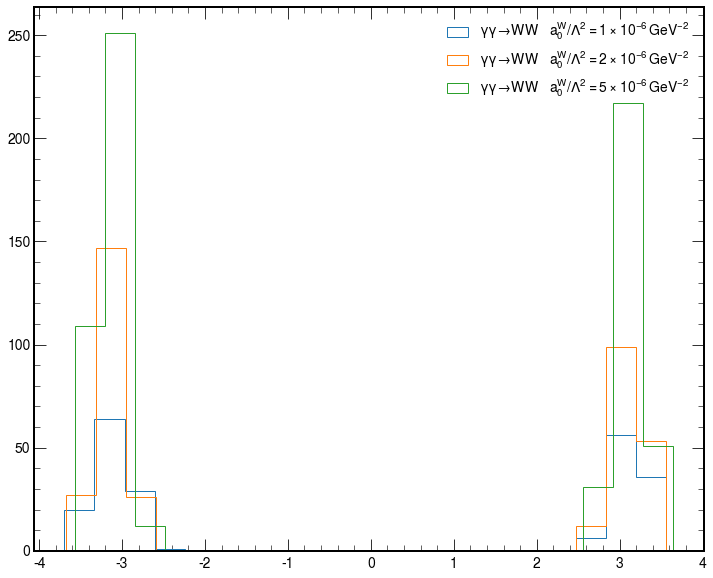

In [7]:
labels_samples = {
    "GGToWW-AQGC-A0W5e-7": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 5 \times 10^{-7} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 1 \times 10^{-6} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 2 \times 10^{-6} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 5 \times 10^{-6} \,\rm{GeV}^{-2}$"
}
labels_samples[ "GGToWW-AQGC-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W5e-7" ] = labels_samples[ "GGToWW-AQGC-A0W5e-7" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W5e-7" ] = labels_samples[ "GGToWW-AQGC-A0W5e-7" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]

if load_signal:
    fig = plt.figure( figsize=(12,10) )
    for label_ in labels_signals: 
        plt.hist( df_signals_protons_multiRP_events[ label_ ]["_nom"][ 'deltaPhi_jet_lep_nom' ], histtype='step', density=False, bins=20, label=labels_samples[ label_ ] )
    plt.legend( loc='best', fontsize=14 )

### MC (Bkg)

In [8]:
load_MC = True

labels_MC = []
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_MC = [ ]
    elif lepton_type == 'electron':
        labels_MC = [ ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_MC = [ "Bkg-2018-muon-TTJets",
                      "Bkg-2018-muon-WJetsToLNu_0J", "Bkg-2018-muon-WJetsToLNu_1J", "Bkg-2018-muon-WJetsToLNu_2J",
                      "Bkg-2018-muon-DYJetsToLL_0J", "Bkg-2018-muon-DYJetsToLL_1J", "Bkg-2018-muon-DYJetsToLL_2J",
                      "Bkg-2018-muon-QCD_Pt_170to300", "Bkg-2018-muon-QCD_Pt_300to470", "Bkg-2018-muon-QCD_Pt_470to600",
                      "Bkg-2018-muon-QCD_Pt_600to800","Bkg-2018-muon-QCD_Pt_800to1000", "Bkg-2018-muon-QCD_Pt_1000to1400",
                      "Bkg-2018-muon-QCD_Pt_1400to1800", "Bkg-2018-muon-QCD_Pt_1800to2400", "Bkg-2018-muon-QCD_Pt_2400to3200", "Bkg-2018-muon-QCD_Pt_3200toInf",
                      "Bkg-2018-muon-ST_s-channel_4f_leptonDecays", "Bkg-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays",
                      "Bkg-2018-muon-ST_t-channel_top_4f_InclusiveDecays","Bkg-2018-muon-ST_tW_antitop_5f_inclusiveDecays", "Bkg-2018-muon-ST_tW_top_5f_inclusiveDecays",
                      "Bkg-2018-muon-WW",
                      "Bkg-2018-muon-WZ",
                      "Bkg-2018-muon-ZZ"
                    ]
    elif lepton_type == 'electron':
        labels_MC = [ "Bkg-2018-electron-TTJets",
                      "Bkg-2018-electron-WJetsToLNu_0J", "Bkg-2018-electron-WJetsToLNu_1J", "Bkg-2018-electron-WJetsToLNu_2J",
                      "Bkg-2018-electron-DYJetsToLL_0J", "Bkg-2018-electron-DYJetsToLL_1J", "Bkg-2018-electron-DYJetsToLL_2J",
                      "Bkg-2018-electron-QCD_Pt_170to300", "Bkg-2018-electron-QCD_Pt_300to470", "Bkg-2018-electron-QCD_Pt_470to600",
                      "Bkg-2018-electron-QCD_Pt_600to800","Bkg-2018-electron-QCD_Pt_800to1000", "Bkg-2018-electron-QCD_Pt_1000to1400",
                      "Bkg-2018-electron-QCD_Pt_1400to1800", "Bkg-2018-electron-QCD_Pt_1800to2400", "Bkg-2018-electron-QCD_Pt_2400to3200", "Bkg-2018-electron-QCD_Pt_3200toInf",
                      "Bkg-2018-electron-ST_s-channel_4f_leptonDecays", "Bkg-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays",
                      "Bkg-2018-electron-ST_t-channel_top_4f_InclusiveDecays","Bkg-2018-electron-ST_tW_antitop_5f_inclusiveDecays", "Bkg-2018-electron-ST_tW_top_5f_inclusiveDecays",
                      "Bkg-2018-electron-WW",
                      "Bkg-2018-electron-WZ",
                      "Bkg-2018-electron-ZZ"
                    ]
    
df_counts_MC = {}
df_events_MC = {}
if load_MC:
    base_path_ = "output_events"
    for label_ in labels_MC:
        print ( label_ )
        file_path_ = "{}/data-store-{}.h5".format( base_path_, label_ )
        with pd.HDFStore( file_path_, 'r' ) as store_:
            print ( list( store_ ) )
            df_counts_MC[ label_ ] = store_[ "counts" ]
            print ( df_counts_MC[ label_ ] )
            df_events_MC[ label_ ] = store_[ "events" ]

Bkg-2018-electron-TTJets
['/counts', '/events']
All           6021909
Jet           6021909
Electron      2749127
check_none    2749127
dtype: int64
Bkg-2018-electron-WJetsToLNu_0J
['/counts', '/events']
All           31
Jet           31
Electron      21
check_none    21
dtype: int64
Bkg-2018-electron-WJetsToLNu_1J
['/counts', '/events']
All           194347
Jet           194347
Electron       90220
check_none     90220
dtype: int64
Bkg-2018-electron-WJetsToLNu_2J
['/counts', '/events']
All           762414
Jet           762414
Electron      352409
check_none    352409
dtype: int64
Bkg-2018-electron-DYJetsToLL_0J
['/counts', '/events']
All           544
Jet           544
Electron      362
check_none    362
dtype: int64
Bkg-2018-electron-DYJetsToLL_1J
['/counts', '/events']
All           164424
Jet           164424
Electron       78873
check_none     78873
dtype: int64
Bkg-2018-electron-DYJetsToLL_2J
['/counts', '/events']
All           627234
Jet           627234
Electron      295320
c

In [9]:
label_ref_ = ""
if data_sample == '2017':
    if lepton_type == 'muon':
        label_ref_ = ''
    elif lepton_type == 'electron':
        label_ref_ = ''
elif data_sample == '2018':
    if lepton_type == 'muon':
#         label_ref_ = 'Bkg-2018-muon-TTJets'
        label_ref_ = 'Bkg-2018-muon-WJetsToLNu_1J'
    elif lepton_type == 'electron':
#         label_ref_ = 'Bkg-2018-electron-TTJets'
        label_ref_ = 'Bkg-2018-electron-WJetsToLNu_1J'


In [10]:
for label_ in labels_MC:
    jet0_tau21, rhoprime1, jet0_tau21_ddt = tau21_ddt_calculation(df_events_MC[ label_ ], lepton_type)
    print(jet0_tau21)
    df_events_MC[ label_ ][ "jet0_tau21" ] = jet0_tau21
    df_events_MC[ label_ ][ "jet0_tau21_nom" ] = jet0_tau21
    df_events_MC[ label_ ][ "jet0_tau21_ddt" ] = jet0_tau21_ddt
    df_events_MC[ label_ ][ "jet0_tau21_ddt_nom" ] = jet0_tau21_ddt

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0         0.663605
1         0.560109
2         0.349822
3         0.445172
4         0.400167
            ...   
749122    0.834950
749123    0.481752
749124    0.464801
749125    0.818264
749126    0.450078
Length: 2749127, dtype: float32
0     0.745617
1     0.687575
2     0.832234
3     0.545609
4     0.774138
5     0.898517
6     0.764794
7     0.642820
8     0.710757
9     0.410060
10    0.748140
11    0.890371
12    0.624830
13    0.741227
14    0.449725
15    0.857097
16    0.726047
17    0.579281
18    0.783213
19    0.743367
20    0.883147
dtype: float32
0        0.728870
1        0.806652
2        0.746263
3        0.751197
4        0.742022
           ...   
90215    0.799976
90216    0.662090
90217    0.850319
90218    0.810711
90219    0.934644
Length: 90220, dtype: float32
0         0.819424
1         0.698249
2         0.806950
3         0.871036
4         0.858127
            ...   
352404    0.880195
352405    0.805421
352406    0.678525
352407    0.744667
352408    0

In [11]:
lepton_var_pt_ = ""
lepton_var_phi_ = ""
lepton_var_eta_ = ""
if lepton_type == 'muon':
    lepton_var_pt_ = "muon0_pt"
    lepton_var_phi_ = "muon0_phi"
    lepton_var_eta_ = "muon0_eta"
elif lepton_type == 'electron':
    lepton_var_pt_ = "electron0_pt"
    lepton_var_phi_ = "electron0_phi"
    lepton_var_eta_ = "electron0_eta"
for label_ in labels_MC:
    df_events_MC[ label_ ]["deltaPhi_jet_lep"] = ( df_events_MC[ label_ ].loc[ :, "jet0_phi"] - df_events_MC[ label_ ].loc[ :, lepton_var_phi_ ] )
    df_events_MC[ label_ ]["deltaPhi_jet_lep_nom"] = ( df_events_MC[ label_ ].loc[ :, "jet0_phi"] - df_events_MC[ label_ ].loc[ :, lepton_var_phi_ ] )

In [12]:
print ( df_events_MC[ label_ref_ ].columns.values )

df_events_MC[ label_ref_ ]

['run' 'lumiblock' 'event' 'crossingAngle' 'betaStar' 'instLumi' 'jet0_pt'
 'jet0_eta' 'jet0_phi' 'jet0_energy' 'jet0_mass' 'jet0_corrmass'
 'jet0_tau1' 'jet0_tau2' 'jet0_vertexz' 'jet0_px' 'jet0_py' 'jet0_pz'
 'calo_met' 'met' 'met_x' 'met_y' 'met_phi' 'nVertices' 'num_bjets_ak8'
 'num_bjets_ak4' 'num_jets_ak4' 'pfcand_nextracks'
 'pfcand_nextracks_noDRl' 'recoMWhad' 'recoMWlep' 'recoMWlep_metJER_Up'
 'recoMWlep_metJER_Down' 'recoMWlep_metJES_Up' 'recoMWlep_metJES_Down'
 'recoMWW' 'recoMWW_metJER_Up' 'recoMWW_metJER_Down' 'recoMWW_metJES_Up'
 'recoMWW_metJES_Down' 'recoRapidityWW' 'dphiWW' 'WLeptonicPt'
 'WLeptonicPt_metJER_Up' 'WLeptonicPt_metJER_Down' 'WLeptonicPt_metJES_Up'
 'WLeptonicPt_metJES_Down' 'WLeptonicEta' 'WLeptonicPhi' 'electron0_pt'
 'electron0_eta' 'electron0_phi' 'electron0_energy' 'electron0_charge'
 'electron0_dxy' 'electron0_dz' 'electron0_corr'
 'electron0_ecalTrkEnPostCorr' 'electron0_ecalTrkEnErrPostCorr'
 'electron0_ecalTrkEnPreCorr' 'electron0_energyScaleValue

,run,lumiblock,event,crossingAngle,betaStar,instLumi,jet0_pt,jet0_eta,jet0_phi,jet0_energy,...,xiCMS_45_jer_up,xiCMS_56_jer_up,xiCMS_45_jer_dw,xiCMS_56_jer_dw,jet0_tau21,jet0_tau21_nom,jet0_tau21_ddt,jet0_tau21_ddt_nom,deltaPhi_jet_lep,deltaPhi_jet_lep_nom
0,1,298,1532234,138.0,0.4,0.0,272.468689,-1.705942,0.013957,778.433899,...,0.032085,0.127297,0.032073,0.126948,0.728870,0.728870,0.752678,0.752678,3.081922,3.081922
1,1,1643,8466389,130.0,0.4,0.0,267.662994,-1.136987,-1.555772,462.568054,...,0.043518,0.073268,0.043578,0.073854,0.806652,0.806652,0.786306,0.786306,-3.338749,-3.338749
2,1,336,1726650,137.0,0.4,0.0,224.365112,-1.988156,-2.666165,836.415833,...,0.004428,0.242743,0.004409,0.241722,0.746263,0.746263,0.728959,0.728959,-3.545073,-3.545073
3,1,336,1729692,137.0,0.4,0.0,203.303391,-1.885373,-1.730205,687.325256,...,0.004180,0.236824,0.004185,0.237015,0.751197,0.751197,0.873995,0.873995,-3.099674,-3.099674
4,1,54446,280613856,156.0,0.4,0.0,216.973373,2.119139,2.127207,918.409363,...,0.156417,0.015263,0.154742,0.015239,0.742022,0.742022,0.805566,0.805566,3.224841,3.224841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90215,1,199731,1029409792,131.0,0.4,0.0,303.449432,-1.051168,1.100055,489.780579,...,0.034618,0.090890,0.034533,0.090197,0.799976,0.799976,0.804293,0.804293,2.905689,2.905689
90216,1,199145,1026392064,152.0,0.4,0.0,333.403442,2.271270,-2.191577,1634.553101,...,0.233049,0.002606,0.243136,0.002713,0.662090,0.662090,0.656022,0.656022,0.122005,0.122005
90217,1,199833,1029938432,135.0,0.4,0.0,240.933701,1.465328,-1.485785,552.862122,...,0.100734,0.020091,0.100412,0.020073,0.850319,0.850319,0.829312,0.829312,-2.492819,-2.492819
90218,1,199834,1029941696,140.0,0.4,0.0,278.352570,0.749975,1.578977,365.837463,...,0.093750,0.018063,0.093568,0.018022,0.810711,0.810711,0.689289,0.689289,3.255537,3.255537


In [13]:
df_events_MC

{'Bkg-2018-electron-TTJets':         run  lumiblock      event  crossingAngle  betaStar  instLumi  \
 0         1        215     555828          152.0       0.4       0.0   
 1         1        215     556012          152.0       0.4       0.0   
 2         1        215     556256          152.0       0.4       0.0   
 3         1        215     557521          152.0       0.4       0.0   
 4         1        215     557984          152.0       0.4       0.0   
 ...     ...        ...        ...            ...       ...       ...   
 749122    1     343663  892491264          138.0       0.4       0.0   
 749123    1     343663  892491712          138.0       0.4       0.0   
 749124    1     343663  892491904          138.0       0.4       0.0   
 749125    1     343663  892492224          138.0       0.4       0.0   
 749126    1     343663  892492672          138.0       0.4       0.0   
 
            jet0_pt  jet0_eta  jet0_phi  jet0_energy  ...  xiCMS_45_jer_up  \
 0       239.379

In [14]:
labels_samples = {
    "Bkg-2018-muon-TTJets": r"$t \bar{t} + \rm{jets}$",
    "Bkg-2018-electron-TTJets": r"$t \bar{t} + \rm{jets}$",
    "Bkg-2018-muon-WJetsToLNu_0J": r"$W + 0\rm{jet}$",
    "Bkg-2018-electron-WJetsToLNu_0J": r"$W + 0\rm{jet}$",
    "Bkg-2018-muon-WJetsToLNu_1J": r"$W + 1\rm{jet}$",
    "Bkg-2018-electron-WJetsToLNu_1J": r"$W + 1\rm{jet}$",
    "Bkg-2018-muon-WJetsToLNu_2J": r"$W + 2\rm{jets}$",
    "Bkg-2018-electron-WJetsToLNu_2J": r"$W + 2\rm{jets}$",
    "Bkg-2018-muon-WJetsToLNu": r"$W + \rm{jets}$",
    "Bkg-2018-electron-WJetsToLNu": r"$W + \rm{jets}$",
    "Bkg-2018-muon-DYJetsToLL_0J": r"$\rm{DY} + 0\rm{jet}$",
    "Bkg-2018-electron-DYJetsToLL_0J": r"$\rm{DY} + 0\rm{jet}$",
    "Bkg-2018-muon-DYJetsToLL_1J": r"$\rm{DY} + 1\rm{jet}$",
    "Bkg-2018-electron-DYJetsToLL_1J": r"$\rm{DY} + 1\rm{jet}$",
    "Bkg-2018-muon-DYJetsToLL_2J": r"$\rm{DY} + 2\rm{jet}$",
    "Bkg-2018-electron-DYJetsToLL_2J": r"$\rm{DY} + 2\rm{jet}$",
    "Bkg-2018-muon-DYJetsToLL": r"$\rm{DY} + \rm{jets}$",
    "Bkg-2018-electron-DYJetsToLL": r"$\rm{DY} + \rm{jets}$",
    "Bkg-2018-muon-QCD_Pt_170to300": r"QCD $170$--$300\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_170to300": r"QCD $170$--$300\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_300to470": r"QCD $300$--$470\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_300to470": r"QCD $300$--$470\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_470to600": r"QCD $470$--$600\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_470to600": r"QCD $470$--$600\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_600to800": r"QCD $600$--$800\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_600to800": r"QCD $600$--$800\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_800to1000": r"QCD $800$--$1000\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_800to1000": r"QCD $800$--$1000\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_1000to1400": r"QCD $1000$--$1400\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_1000to1400": r"QCD $1000$--$1400\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_1400to1800": r"QCD $1400$--$1800\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_1400to1800": r"QCD $1400$--$1800\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_1800to2400": r"QCD $1800$--$2400\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_1800to2400": r"QCD $1800$--$2400\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_2400to3200": r"QCD $2400$--$3200\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_2400to3200": r"QCD $2400$--$3200\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_3200toInf": r"QCD $3200$--$\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_3200toInf": r"QCD $3200$--$\,\rm{GeV}$",
    "Bkg-2018-muon-QCD": r"QCD",
    "Bkg-2018-electron-QCD": r"QCD",
    "Bkg-2018-muon-ST_s-channel_4f_leptonDecays": r"single top $s$-channel $4f$",
    "Bkg-2018-electron-ST_s-channel_4f_leptonDecays": r"single top $s$-channel $4f$",
    "Bkg-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays": r"single top $t$-channel $\bar{t}$ $4f$",
    "Bkg-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays": r"single top $t$-channel $\bar{t}$ $4f$",
    "Bkg-2018-muon-ST_t-channel_top_4f_InclusiveDecays": r"single top $t$-channel $t$ $4f$",
    "Bkg-2018-electron-ST_t-channel_top_4f_InclusiveDecays": r"single top $t$-channel $t$ $4f$",
    "Bkg-2018-muon-ST_tW_antitop_5f_inclusiveDecays": r"single top $tW$ $\bar{t}$ $5f$",
    "Bkg-2018-electron-ST_tW_antitop_5f_inclusiveDecays": r"single top $tW$ $\bar{t}$ $5f$",
    "Bkg-2018-muon-ST_tW_top_5f_inclusiveDecays": r"single top $tW$ $t$ $5f$",
    "Bkg-2018-electron-ST_tW_top_5f_inclusiveDecays": r"single top $tW$ $t$ $5f$",
    "Bkg-2018-muon-ST": r"single top",
    "Bkg-2018-electron-ST": r"single top",
    "Bkg-2018-muon-WW": r"$WW$",
    "Bkg-2018-electron-WW": r"$WW$",
    "Bkg-2018-muon-WZ": r"$WZ$",
    "Bkg-2018-electron-WZ": r"$WZ$",
    "Bkg-2018-muon-ZZ": r"$ZZ$",
    "Bkg-2018-electron-ZZ": r"$ZZ$",
    "Bkg-2018-muon-VV": r"$VV$",
    "Bkg-2018-electron-VV": r"$VV$"
}

In [15]:
##var__ = "jet0_pt_nom"
##if load_MC:
##    fig = plt.figure( figsize=(12,10) )
##    for label__ in labels_MC: 
##        plt.hist( df_events_MC[ label__ ][ var__ ], histtype='step', density=False, bins=50, label=labels_samples[ label__ ] )
##    plt.legend( loc='best', fontsize=14 )

### Select events

In [16]:
df_selected_events_MC = {}

variations_ = { "jet": [ "_jes_up", "_jes_dw", "_jer_up", "_jer_dw" ] }
for label__ in labels_MC:
    print ( label__ )
    df_events__ = df_events_MC[ label__ ]
    print ( df_events__.shape[0] )
    df_selected_events__, selection_keys__, selections__, deltaPhi_jet_lep_  = select_events( df_events__, lepton_type )
    print ( df_selected_events__.shape[0] )
    print ( selection_keys__ )
    print ( selections__ )
    df_selected_events_MC[ label__ ] = {}
    df_selected_events_MC[ label__ ][ "_nom" ] = df_selected_events__
    for var_label__ in variations_:
        print ( var_label__ )
        for variation__ in variations_[ var_label__ ]:
            opt__ = { "label_" + var_label__ : variation__ }
            print ( opt__ )
            df_selected_events__, selection_keys__, selections__, deltaPhi_jet_lep_  = select_events( df_events__, lepton_type, **opt__ )
            print ( df_selected_events__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_selected_events_MC[ label__ ][ variation__ ] = df_selected_events__

Bkg-2018-electron-TTJets
2749127


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


94201
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 2749127, 'Electron': 2747941, 'Jet': 2136969, 'Jet_Electron': 2085814, 'MET': 976526, 'Jet_MET': 925628, 'PrunedMass': 431514, 'Tau21': 292225, 'BJet_Veto': 171158, 'Xi_CMS': 156105, 'WLeptonic': 125680, 'Jet_WLeptonic': 121263, 'MWW': 116778, 'ExtraTracks': 116778, 'HEM Failure': 94201}
jet
{'label_jet': '_jes_up'}


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


94185
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 2749127, 'Electron': 2747941, 'Jet': 2205241, 'Jet_Electron': 2150886, 'MET': 999024, 'Jet_MET': 945969, 'PrunedMass': 438762, 'Tau21': 295144, 'BJet_Veto': 172828, 'Xi_CMS': 157292, 'WLeptonic': 126135, 'Jet_WLeptonic': 121638, 'MWW': 116716, 'ExtraTracks': 116716, 'HEM Failure': 94185}
{'label_jet': '_jes_dw'}


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


94121
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 2749127, 'Electron': 2747941, 'Jet': 2069739, 'Jet_Electron': 2021492, 'MET': 954082, 'Jet_MET': 905289, 'PrunedMass': 423956, 'Tau21': 288909, 'BJet_Veto': 169306, 'Xi_CMS': 154765, 'WLeptonic': 125129, 'Jet_WLeptonic': 120819, 'MWW': 116727, 'ExtraTracks': 116727, 'HEM Failure': 94121}
{'label_jet': '_jer_up'}


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


94008
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 2749127, 'Electron': 2747941, 'Jet': 2127472, 'Jet_Electron': 2076414, 'MET': 973231, 'Jet_MET': 922812, 'PrunedMass': 430205, 'Tau21': 291157, 'BJet_Veto': 170594, 'Xi_CMS': 155583, 'WLeptonic': 125346, 'Jet_WLeptonic': 120938, 'MWW': 116546, 'ExtraTracks': 116546, 'HEM Failure': 94008}
{'label_jet': '_jer_dw'}


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


94294
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 2749127, 'Electron': 2747941, 'Jet': 2129087, 'Jet_Electron': 2078498, 'MET': 973565, 'Jet_MET': 922921, 'PrunedMass': 430885, 'Tau21': 292202, 'BJet_Veto': 171176, 'Xi_CMS': 156121, 'WLeptonic': 125748, 'Jet_WLeptonic': 121339, 'MWW': 116900, 'ExtraTracks': 116900, 'HEM Failure': 94294}
Bkg-2018-electron-WJetsToLNu_0J
21
0
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 21, 'Electron': 21, 'Jet': 12, 'Jet_Electron': 11, 'MET': 2, 'Jet_MET': 2, 'PrunedMass': 0, 'Tau21': 0, 'BJet_Veto': 0, 'Xi_CMS': 0, 'WLeptonic': 0, 'Jet_WLeptonic': 0, 'MWW': 0, 'ExtraTracks': 0, 'HEM Failure': 0}
jet
{'label_jet': '_jes_up'}
0
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


32
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 78873, 'Electron': 78845, 'Jet': 51868, 'Jet_Electron': 51757, 'MET': 4329, 'Jet_MET': 4182, 'PrunedMass': 351, 'Tau21': 66, 'BJet_Veto': 66, 'Xi_CMS': 61, 'WLeptonic': 48, 'Jet_WLeptonic': 48, 'MWW': 41, 'ExtraTracks': 41, 'HEM Failure': 32}
jet
{'label_jet': '_jes_up'}
32
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 78873, 'Electron': 78845, 'Jet': 54802, 'Jet_Electron': 54677, 'MET': 4454, 'Jet_MET': 4304, 'PrunedMass': 367, 'Tau21': 67, 'BJet_Veto': 67, 'Xi_CMS': 61, 'WLeptonic': 48, 'Jet_WLeptonic': 48, 'MWW': 40, 'ExtraTracks': 40, 'HEM Failure': 32}
{'label_jet': '_jes_dw'}
31
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJ

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


32
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 78873, 'Electron': 78845, 'Jet': 51327, 'Jet_Electron': 51224, 'MET': 4294, 'Jet_MET': 4149, 'PrunedMass': 343, 'Tau21': 64, 'BJet_Veto': 64, 'Xi_CMS': 60, 'WLeptonic': 47, 'Jet_WLeptonic': 47, 'MWW': 42, 'ExtraTracks': 42, 'HEM Failure': 32}
Bkg-2018-electron-DYJetsToLL_2J
295320
433
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 295320, 'Electron': 294290, 'Jet': 209909, 'Jet_Electron': 207651, 'MET': 13916, 'Jet_MET': 12653, 'PrunedMass': 2268, 'Tau21': 927, 'BJet_Veto': 909, 'Xi_CMS': 771, 'WLeptonic': 593, 'Jet_WLeptonic': 571, 'MWW': 543, 'ExtraTracks': 543, 'HEM Failure': 433}
jet
{'label_jet': '_jes_up'}
438
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_M

5
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 5684, 'Electron': 5684, 'Jet': 5680, 'Jet_Electron': 5670, 'MET': 720, 'Jet_MET': 230, 'PrunedMass': 30, 'Tau21': 15, 'BJet_Veto': 15, 'Xi_CMS': 6, 'WLeptonic': 6, 'Jet_WLeptonic': 6, 'MWW': 6, 'ExtraTracks': 6, 'HEM Failure': 5}
Bkg-2018-electron-QCD_Pt_800to1000
3381
3
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 3381, 'Electron': 3381, 'Jet': 3380, 'Jet_Electron': 3377, 'MET': 654, 'Jet_MET': 185, 'PrunedMass': 24, 'Tau21': 13, 'BJet_Veto': 13, 'Xi_CMS': 4, 'WLeptonic': 4, 'Jet_WLeptonic': 4, 'MWW': 4, 'ExtraTracks': 4, 'HEM Failure': 3}
jet
{'label_jet': '_jes_up'}
3
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_

0
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 163, 'Electron': 163, 'Jet': 163, 'Jet_Electron': 163, 'MET': 101, 'Jet_MET': 39, 'PrunedMass': 12, 'Tau21': 8, 'BJet_Veto': 8, 'Xi_CMS': 0, 'WLeptonic': 0, 'Jet_WLeptonic': 0, 'MWW': 0, 'ExtraTracks': 0, 'HEM Failure': 0}
Bkg-2018-electron-ST_s-channel_4f_leptonDecays
105995
997
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 105995, 'Electron': 105995, 'Jet': 83701, 'Jet_Electron': 83063, 'MET': 39205, 'Jet_MET': 38428, 'PrunedMass': 6419, 'Tau21': 2836, 'BJet_Veto': 1922, 'Xi_CMS': 1654, 'WLeptonic': 1297, 'Jet_WLeptonic': 1279, 'MWW': 1226, 'ExtraTracks': 1226, 'HEM Failure': 997}
jet
{'label_jet': '_jes_up'}
997
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_ME

3080
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 54397, 'Electron': 54391, 'Jet': 42359, 'Jet_Electron': 41800, 'MET': 21500, 'Jet_MET': 20808, 'PrunedMass': 10253, 'Tau21': 7388, 'BJet_Veto': 5037, 'Xi_CMS': 4600, 'WLeptonic': 3991, 'Jet_WLeptonic': 3897, 'MWW': 3777, 'ExtraTracks': 3777, 'HEM Failure': 3080}
{'label_jet': '_jer_dw'}
3089
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 54397, 'Electron': 54391, 'Jet': 42322, 'Jet_Electron': 41768, 'MET': 21509, 'Jet_MET': 20807, 'PrunedMass': 10270, 'Tau21': 7409, 'BJet_Veto': 5047, 'Xi_CMS': 4618, 'WLeptonic': 4014, 'Jet_WLeptonic': 3919, 'MWW': 3793, 'ExtraTracks': 3793, 'HEM Failure': 3089}
Bkg-2018-electron-ST_tW_top_5f_inclusiveDecays
56419
3318
['All', 'Electron

In [17]:
df_selected_events_MC

{'Bkg-2018-electron-TTJets': {'_nom':         run  lumiblock      event  crossingAngle  betaStar  instLumi  \
  6         1        216     559158          152.0       0.4       0.0   
  23        1     327229  849813312          153.0       0.4       0.0   
  82        1     102082  265104656          136.0       0.4       0.0   
  95        1      74122  192492768          137.0       0.4       0.0   
  130       1     200585  520918368          148.0       0.4       0.0   
  ...     ...        ...        ...            ...       ...       ...   
  749016    1     334301  868179456          130.0       0.4       0.0   
  749048    1     321939  836073216          152.0       0.4       0.0   
  749080    1     334469  868613696          130.0       0.4       0.0   
  749092    1     334469  868615616          130.0       0.4       0.0   
  749108    1     334418  868483200          140.0       0.4       0.0   
  
             jet0_pt  jet0_eta  jet0_phi  jet0_energy  ...  xiCMS_45_jer_

In [18]:
import json
samples_info = None
if data_sample == '2017':
    pass
elif data_sample == '2018':
    samples_info = json.load( open( 'samples_info_UL18_XSDB.json' ) )
samples_info

{'FPMC_WW_bSM_13tev_a0w_1e-6_aCw_0_semi_pt0': [100000.0, 0.045393, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_2e-6_aCw_0_semi_pt0': [100000.0, 0.058313, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_5e-6_aCw_0_semi_pt0': [100000.0, 0.148122, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_2e-5_semi_pt0': [99000.0, 0.16477, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_5e-6_semi_pt0': [100000.0, 0.049199, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_8e-6_semi_pt0': [100000.0, 0.061404, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_0_semi_pt0': [262999.0, 0.0409705, 1.0, 6],
 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8': [306142140.0, 831.76, 1.0, 800],
 'WW_TuneCP5_13TeV-pythia8': [15679000.0, 75.95, 1.0, 800],
 'WZ_TuneCP5_13TeV-pythia8': [7940000.0, 27.59, 1.0, 800],
 'ZZ_TuneCP5_13TeV-pythia8': [3526000.0, 12.17, 1.0, 800],
 'ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8': [19366000.0,
  3.549,
  1.0,
  800],
 'ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8': [178756000.0,
  115.3,
  1.0,
  800],

In [19]:
sample_names = {}
if data_sample == '2017':
    pass
elif data_sample == '2018':
    sample_names[ "Bkg-2018-muon-TTJets" ] = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-muon-WJetsToLNu_0J" ] = 'WJetsToLNu_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-muon-WJetsToLNu_1J" ] = 'WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-muon-WJetsToLNu_2J" ] = 'WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-muon-WW" ] = 'WW_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-WZ" ] = 'WZ_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-ZZ" ] = 'ZZ_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-ST_s-channel_4f_leptonDecays" ] = 'ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8'
    sample_names[ "Bkg-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays" ] = 'ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
    sample_names[ "Bkg-2018-muon-ST_t-channel_top_4f_InclusiveDecays" ] = 'ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
    sample_names[ "Bkg-2018-muon-ST_tW_antitop_5f_inclusiveDecays" ] = 'ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
    sample_names[ "Bkg-2018-muon-ST_tW_top_5f_inclusiveDecays" ] = 'ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
    sample_names[ "Bkg-2018-muon-DYJetsToLL_0J" ] = 'DYJetsToLL_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-muon-DYJetsToLL_1J" ] = 'DYJetsToLL_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-muon-DYJetsToLL_2J" ] = 'DYJetsToLL_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_170to300" ] = 'QCD_Pt_170to300_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_300to470" ] = 'QCD_Pt_300to470_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_470to600" ] = 'QCD_Pt_470to600_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_600to800" ] = 'QCD_Pt_600to800_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_800to1000" ] = 'QCD_Pt_800to1000_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_1000to1400" ] = 'QCD_Pt_1000to1400_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_1400to1800" ] = 'QCD_Pt_1400to1800_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_1800to2400" ] = 'QCD_Pt_1800to2400_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_2400to3200" ] = 'QCD_Pt_2400to3200_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_3200toInf" ] = 'QCD_Pt_3200toInf_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-TTJets" ] = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-electron-WJetsToLNu_0J" ] = 'WJetsToLNu_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-electron-WJetsToLNu_1J" ] = 'WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-electron-WJetsToLNu_2J" ] = 'WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-electron-WW" ] = 'WW_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-WZ" ] = 'WZ_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-ZZ" ] = 'ZZ_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-ST_s-channel_4f_leptonDecays" ] = 'ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8'
    sample_names[ "Bkg-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays" ] = 'ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
    sample_names[ "Bkg-2018-electron-ST_t-channel_top_4f_InclusiveDecays" ] = 'ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
    sample_names[ "Bkg-2018-electron-ST_tW_antitop_5f_inclusiveDecays" ] = 'ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
    sample_names[ "Bkg-2018-electron-ST_tW_top_5f_inclusiveDecays" ] = 'ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
    sample_names[ "Bkg-2018-electron-DYJetsToLL_0J" ] = 'DYJetsToLL_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-electron-DYJetsToLL_1J" ] = 'DYJetsToLL_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-electron-DYJetsToLL_2J" ] = 'DYJetsToLL_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_170to300" ] = 'QCD_Pt_170to300_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_300to470" ] = 'QCD_Pt_300to470_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_470to600" ] = 'QCD_Pt_470to600_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_600to800" ] = 'QCD_Pt_600to800_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_800to1000" ] = 'QCD_Pt_800to1000_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_1000to1400" ] = 'QCD_Pt_1000to1400_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_1400to1800" ] = 'QCD_Pt_1400to1800_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_1800to2400" ] = 'QCD_Pt_1800to2400_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_2400to3200" ] = 'QCD_Pt_2400to3200_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_3200toInf" ] = 'QCD_Pt_3200toInf_TuneCP5_13TeV-pythia8'


In [20]:
lumi_periods = None
if data_sample == '2017':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2017[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2017[ 'electron' ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2018[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2018[ 'electron' ]
    
lumi = np.sum( list( lumi_periods.values() ) )
print ( lumi )
    
norm_factors = {}
for label__ in labels_MC:
    print ( label__ )
    print ( samples_info[ sample_names[ label__ ] ] )
    sample_nevents_, sample_cross_section_, sel_eff_, _ = samples_info[ sample_names[ label__ ] ]
    sample_cross_section_ = sample_cross_section_ * sel_eff_
#     if norm_to_1fb:
#         sample_cross_section_ = 1.e-03
    print ( sample_cross_section_ )
    norm_factors[ label__ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
    print ( norm_factors[ label__ ] )
    norm_factors_product_ = np.product( norm_factors[ label__ ] )
    print ( norm_factors_product_ )
    if df_selected_events_MC[ label__ ][ "_nom" ].shape[0] > 0:
        df_selected_events_MC[ label__ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_
    for variation__ in df_selected_events_MC[ label__ ]:
        print ( variation__ )
        if df_selected_events_MC[ label__ ][ variation__ ].shape[0] > 0:
            df_selected_events_MC[ label__ ][ variation__ ].loc[ :, "norm" ] = norm_factors_product_

55.702914022
Bkg-2018-electron-TTJets
[306142140.0, 831.76, 1.0, 800]
831.76
[1.81951149e-07 8.31760000e+05 1.00000000e+00]
0.15133968739794765
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-electron-WJetsToLNu_0J
[172138160.0, 53330, 1.0, 800]
53330.0
[3.23594222e-07 5.33300000e+07 1.00000000e+00]
17.257279877937933
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-electron-WJetsToLNu_1J
[184528800.0, 8875, 1.0, 800]
8875.0
[3.01865693e-07 8.87500000e+06 1.00000000e+00]
2.6790580220824607
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-electron-WJetsToLNu_2J
[94925912.0, 3338, 1.0, 800]
3338.0
[5.86804096e-07 3.33800000e+06 1.00000000e+00]
1.9587520739904611
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-electron-DYJetsToLL_0J
[86443200.0, 5129, 1.0, 800]
5129.0
[6.44387459e-07 5.12900000e+06 1.00000000e+00]
3.3050632787638357
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-electron-DYJetsToLL_1J
[92022392.0, 951.5, 1.0, 800]
951.5
[6.05319127e-07 9.51500000e+05 1.00000000e+00]
0.57596114967249

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [21]:
lumi_periods = None
if data_sample == '2017':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2017[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2017[ 'electron' ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2018[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2018[ 'electron' ]
    
lumi = np.sum( list( lumi_periods.values() ) )
print ( lumi )

#labels_signals = [ "GGToWW-AQGC-test-A0W1e-6", "GGToWW-AQGC-test-A0W2e-6", "GGToWW-AQGC-test-A0W5e-6" ]
sample_names = {}
if data_sample == '2017':
    if lepton_type == 'muon':
        sample_names[ "GGToWW-AQGC-2017-muon-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
        sample_names[ "GGToWW-AQGC-2017-muon-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
        sample_names[ "GGToWW-AQGC-2017-muon-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"
    if lepton_type == 'electron':
        sample_names[ "GGToWW-AQGC-2017-electron-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
        sample_names[ "GGToWW-AQGC-2017-electron-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
        sample_names[ "GGToWW-AQGC-2017-electron-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"
elif data_sample == '2018':
    if lepton_type == 'muon':
        sample_names[ "GGToWW-AQGC-2018-muon-A0W1e-6" ] = "FPMC_WW_bSM_13tev_a0w_1e-6_aCw_0_semi_pt0"
        sample_names[ "GGToWW-AQGC-2018-muon-A0W2e-6" ] = "FPMC_WW_bSM_13tev_a0w_2e-6_aCw_0_semi_pt0"
        sample_names[ "GGToWW-AQGC-2018-muon-A0W5e-6" ] = "FPMC_WW_bSM_13tev_a0w_5e-6_aCw_0_semi_pt0"
    if lepton_type == 'electron':
        sample_names[ "GGToWW-AQGC-2018-electron-A0W1e-6" ] = "FPMC_WW_bSM_13tev_a0w_1e-6_aCw_0_semi_pt0"
        sample_names[ "GGToWW-AQGC-2018-electron-A0W2e-6" ] = "FPMC_WW_bSM_13tev_a0w_2e-6_aCw_0_semi_pt0"
        sample_names[ "GGToWW-AQGC-2018-electron-A0W5e-6" ] = "FPMC_WW_bSM_13tev_a0w_5e-6_aCw_0_semi_pt0"
    
norm_factors = {}
for label_ in labels_signals:
    print ( label_ )
    print ( samples_info[ sample_names[ label_ ] ] )
    sample_nevents_, sample_cross_section_, sel_eff_, _ = samples_info[ sample_names[ label_ ] ]
    sample_cross_section_ = sample_cross_section_ * sel_eff_
#    if norm_to_1fb:
#        sample_cross_section_ = 1.e-03
#     if data_sample == '2018':
#         sample_cross_section_ *= ( 0.14271*(1.174) )
    print ( sample_cross_section_ )
    #norm_factors[ label_ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
    norm_factors[ label_ ] = np.array( [ lumi*2000 / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
    print ( norm_factors[ label_ ] )
    norm_factors_product_ = np.product( norm_factors[ label_ ] )
#     df_signals_protons_multiRP_events[ label_ ].loc[ :, "norm" ] = norm_factors_product_
    df_signals_protons_multiRP_events[ label_ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_

55.702914022
GGToWW-AQGC-2018-electron-A0W1e-6
[100000.0, 0.045393, 1.0, 6]
0.045393
[ 1.11405828 45.393       1.        ]
GGToWW-AQGC-2018-electron-A0W2e-6
[100000.0, 0.058313, 1.0, 6]
0.058313
[ 1.11405828 58.313       1.        ]
GGToWW-AQGC-2018-electron-A0W5e-6
[100000.0, 0.148122, 1.0, 6]
0.148122
[  1.11405828 148.122        1.        ]


In [22]:
var_name__ = ""
if lepton_type == 'muon':
    var_name__ = "sf_muon_id"
elif lepton_type == 'electron':
    var_name__ = "sf_electron_id"
var_name_up__ = var_name__ + "_up"
var_name_dw__ = var_name__ + "_dw"

df_selected_events_MC[ "Bkg-2018-"+lepton_type+"-TTJets" ][ "_nom" ][ [ var_name__, var_name_up__, var_name_dw__ ] ]

,sf_electron_id,sf_electron_id_up,sf_electron_id_dw
6,1.016055,1.037929,0.994181
23,1.007168,1.020547,0.993790
82,0.962287,0.974066,0.950508
95,0.962287,0.974066,0.950508
130,0.962629,0.966570,0.958687
...,...,...,...
749016,1.000000,1.013321,0.986679
749048,0.962629,0.966570,0.958687
749080,0.962287,0.974066,0.950508
749092,0.983927,0.997163,0.970690


In [24]:
df_selected_events_MC[ "Bkg-2018-"+lepton_type+"-TTJets" ][ "_nom" ][ [ "pileupWeight" ] ]

,pileupWeight
6,0.806781
23,0.918710
82,1.006624
95,0.998228
130,1.011660
...,...
749016,1.011660
749048,1.006624
749080,0.992600
749092,0.992600


In [25]:
label_WJetsToLNu = ''
samples_WJetsToLNu = []
label_DYJetsToLL = ''
samples_DYJetsToLL = []
label_QCD = ''
samples_QCD = []
label_ST = ''
samples_ST = []
label_VV = ''
samples_VV = []
if data_sample == '2017':
    if lepton_type == 'muon':
        label_WJetsToLNu = ''
        samples_WJetsToLNu = [ ]
        label_DYJetsToLL = ''
        samples_DYJetsToLL = []
        label_QCD = ''
        samples_QCD = []
        label_ST = ''
        samples_ST = []
        label_VV = ''
        samples_VV = []
    elif lepton_type == 'electron':
        label_WJetsToLNu = ''
        samples_WJetsToLNu = [ ]
        label_DYJetsToLL = ''
        samples_DYJetsToLL = []
        label_QCD = ''
        samples_QCD = []
        label_ST = ''
        samples_ST = []
        label_VV = ''
        samples_VV = []
elif data_sample == '2018':
    if lepton_type == 'muon':
        label_WJetsToLNu = "Bkg-2018-muon-WJetsToLNu"
        samples_WJetsToLNu = [ "Bkg-2018-muon-WJetsToLNu_0J", "Bkg-2018-muon-WJetsToLNu_1J", "Bkg-2018-muon-WJetsToLNu_2J" ]
        label_DYJetsToLL = "Bkg-2018-muon-DYJetsToLL"
        samples_DYJetsToLL = [ "Bkg-2018-muon-DYJetsToLL_0J", "Bkg-2018-muon-DYJetsToLL_1J", "Bkg-2018-muon-DYJetsToLL_2J" ]
        label_QCD = "Bkg-2018-muon-QCD"
        samples_QCD = [ "Bkg-2018-muon-QCD_Pt_170to300", "Bkg-2018-muon-QCD_Pt_300to470", "Bkg-2018-muon-QCD_Pt_470to600",
                        "Bkg-2018-muon-QCD_Pt_600to800","Bkg-2018-muon-QCD_Pt_800to1000", "Bkg-2018-muon-QCD_Pt_1000to1400",
                        "Bkg-2018-muon-QCD_Pt_1400to1800", "Bkg-2018-muon-QCD_Pt_1800to2400", "Bkg-2018-muon-QCD_Pt_2400to3200", "Bkg-2018-muon-QCD_Pt_3200toInf" ]
        label_ST = "Bkg-2018-muon-ST"
        samples_ST = [ "Bkg-2018-muon-ST_s-channel_4f_leptonDecays", "Bkg-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays",
                       "Bkg-2018-muon-ST_t-channel_top_4f_InclusiveDecays","Bkg-2018-muon-ST_tW_antitop_5f_inclusiveDecays", "Bkg-2018-muon-ST_tW_top_5f_inclusiveDecays" ]
        label_VV = "Bkg-2018-muon-VV"
        samples_VV = [ "Bkg-2018-muon-WW",
                       "Bkg-2018-muon-WZ",
                       "Bkg-2018-muon-ZZ" ]
    elif lepton_type == 'electron':
        label_WJetsToLNu = "Bkg-2018-electron-WJetsToLNu"
        samples_WJetsToLNu = [ "Bkg-2018-electron-WJetsToLNu_0J", "Bkg-2018-electron-WJetsToLNu_1J", "Bkg-2018-electron-WJetsToLNu_2J" ]
        label_DYJetsToLL = "Bkg-2018-electron-DYJetsToLL"
        samples_DYJetsToLL = [ "Bkg-2018-electron-DYJetsToLL_0J", "Bkg-2018-electron-DYJetsToLL_1J", "Bkg-2018-electron-DYJetsToLL_2J" ]
        label_QCD = "Bkg-2018-electron-QCD"
        samples_QCD = [ "Bkg-2018-electron-QCD_Pt_170to300", "Bkg-2018-electron-QCD_Pt_300to470", "Bkg-2018-electron-QCD_Pt_470to600",
                        "Bkg-2018-electron-QCD_Pt_600to800","Bkg-2018-electron-QCD_Pt_800to1000", "Bkg-2018-electron-QCD_Pt_1000to1400",
                        "Bkg-2018-electron-QCD_Pt_1400to1800", "Bkg-2018-electron-QCD_Pt_1800to2400", "Bkg-2018-electron-QCD_Pt_2400to3200", "Bkg-2018-electron-QCD_Pt_3200toInf" ]
        label_ST = "Bkg-2018-electron-ST"
        samples_ST = [ "Bkg-2018-electron-ST_s-channel_4f_leptonDecays", "Bkg-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays",
                       "Bkg-2018-electron-ST_t-channel_top_4f_InclusiveDecays","Bkg-2018-electron-ST_tW_antitop_5f_inclusiveDecays", "Bkg-2018-electron-ST_tW_top_5f_inclusiveDecays" ]
        label_VV = "Bkg-2018-electron-VV"
        samples_VV = [ "Bkg-2018-electron-WW",
                       "Bkg-2018-electron-WZ",
                       "Bkg-2018-electron-ZZ" ]

df_selected_events_MC[ label_WJetsToLNu ] = {}
df_selected_events_MC[ label_DYJetsToLL ] = {}
df_selected_events_MC[ label_QCD ] = {}
df_selected_events_MC[ label_ST ] = {}
df_selected_events_MC[ label_VV ] = {}
for variation__ in df_selected_events_MC[ samples_WJetsToLNu[ 0 ] ]:
    print ( variation__ )
    df_events_list__ = []
    for label__ in samples_WJetsToLNu:
        df_events_list__.append( df_selected_events_MC[ label__ ][ variation__ ] )
    df_selected_events_MC[ label_WJetsToLNu ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_DYJetsToLL:
        df_events_list__.append( df_selected_events_MC[ label__ ][ variation__ ] )
    df_selected_events_MC[ label_DYJetsToLL ][ variation__ ] = pd.concat( df_events_list__ )

    df_events_list__ = []
    for label__ in samples_QCD:
        df_events_list__.append( df_selected_events_MC[ label__ ][ variation__ ] )
    df_selected_events_MC[ label_QCD ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_ST:
        df_events_list__.append( df_selected_events_MC[ label__ ][ variation__ ] )
    df_selected_events_MC[ label_ST ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_VV:
        df_events_list__.append( df_selected_events_MC[ label__ ][ variation__ ] )
    df_selected_events_MC[ label_VV ][ variation__ ] = pd.concat( df_events_list__ )
    
labels_MC.append( label_WJetsToLNu )
labels_MC.append( label_DYJetsToLL )
labels_MC.append( label_QCD )
labels_MC.append( label_ST )
labels_MC.append( label_VV )
# print ( df_selected_events_MC[ label_WJetsToLNu ] )

_nom
_jes_up
_jes_dw
_jer_up
_jer_dw


In [26]:
df_selected_events_MC[ label_QCD ]

{'_nom':       run  lumiblock     event  crossingAngle  betaStar  instLumi  \
 2840    1      34653  34652108          152.0       0.4       0.0   
 2941    1      37026  37025864          156.0       0.4       0.0   
 460     1      11320  11319122          130.0       0.4       0.0   
 510     1      12188  12187775          152.0       0.4       0.0   
 1513    1      45697  45696268          153.0       0.4       0.0   
 4126    1      36089  36088932          152.0       0.4       0.0   
 4743    1      45752  45751440          130.0       0.4       0.0   
 975     1      34317  34316728          156.0       0.4       0.0   
 2302    1       9058   9057318          152.0       0.4       0.0   
 3215    1      30813  30812796          156.0       0.4       0.0   
 629     1      13220  13219006          153.0       0.4       0.0   
 30      1       2494   2493479          152.0       0.4       0.0   
 
           jet0_pt  jet0_eta  jet0_phi  jet0_energy  ...  xiCMS_56_jer_up  \
 28

In [40]:
variations_weights_ = [ "nom" ]

if lepton_type == 'muon':
    variations_weights_sf_muon_id_ = [ "sf_muon_id_up", "sf_muon_id_dw" ]
    variations_weights_.extend( variations_weights_sf_muon_id_ )
    variations_weights_sf_muon_trigger_ = [ "sf_muon_trigger_up", "sf_muon_trigger_dw" ]
    variations_weights_.extend( variations_weights_sf_muon_trigger_ )
elif lepton_type == 'electron':
    variations_weights_sf_electron_id_ = [ "sf_electron_id_up", "sf_electron_id_dw" ]
    variations_weights_.extend( variations_weights_sf_electron_id_ )
    variations_weights_sf_electron_trigger_ = [ "sf_electron_trigger_up", "sf_electron_trigger_dw" ]
    variations_weights_.extend( variations_weights_sf_electron_trigger_ )

variations_weights_sf_prefiring_ = [ "sf_prefiring_up", "sf_prefiring_dw" ]
variations_weights_.extend( variations_weights_sf_prefiring_ )    
    
var_names_sf_lepton_id__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_muon_trigger_up", "sf_muon_trigger_dw" ]: var_names_sf_lepton_id__[ key_ ] = "sf_muon_id"
    var_names_sf_lepton_id__[ "sf_muon_id_up" ] = "sf_muon_id_up"
    var_names_sf_lepton_id__[ "sf_muon_id_dw" ] = "sf_muon_id_dw"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_electron_trigger_up", "sf_electron_trigger_dw" ]: var_names_sf_lepton_id__[ key_ ] = "sf_electron_id"
    var_names_sf_lepton_id__[ "sf_electron_id_up" ] = "sf_electron_id_up"
    var_names_sf_lepton_id__[ "sf_electron_id_dw" ] = "sf_electron_id_dw"
    
var_names_sf_trigger__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_muon_id_up", "sf_muon_id_dw" ]:
        var_names_sf_trigger__[ key_ ] = "sf_muon_trigger"
    var_names_sf_trigger__[ "sf_muon_trigger_up" ] = "sf_muon_trigger_up"
    var_names_sf_trigger__[ "sf_muon_trigger_dw" ] = "sf_muon_trigger_dw"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_electron_id_up", "sf_electron_id_dw" ]:
        var_names_sf_trigger__[ key_ ] = "sf_electron_trigger"
    var_names_sf_trigger__[ "sf_electron_trigger_up" ] = "sf_electron_trigger_up"
    var_names_sf_trigger__[ "sf_electron_trigger_dw" ] = "sf_electron_trigger_dw"

var_names_sf_prefiring__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_muon_id_up", "sf_muon_id_dw",
                  "sf_muon_trigger_up", "sf_muon_trigger_dw" ]:
        var_names_sf_prefiring__[ key_ ] = "prefiring_weight_Muon"
#     var_names_sf_prefiring__[ "sf_prefiring_up" ] = "prefiring_weight_Muon_up"
#     var_names_sf_prefiring__[ "sf_prefiring_dw" ] = "prefiring_weight_Muon_dw"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_electron_id_up", "sf_electron_id_dw",
                  "sf_electron_trigger_up", "sf_electron_trigger_dw" ]:
        var_names_sf_prefiring__[ key_ ] = "prefiring_weight"
var_names_sf_prefiring__[ "sf_prefiring_up" ] = "prefiring_weight_up"
var_names_sf_prefiring__[ "sf_prefiring_dw" ] = "prefiring_weight_down"
    
print ( variations_weights_ )
print ( var_names_sf_lepton_id__ )
print ( var_names_sf_trigger__ )
print ( var_names_sf_prefiring__ )

weights_events_MC = {}
weights_events_sig = {}
for label__ in labels_MC:
    print ( label__ )
    
    weights_events_MC[ label__ ] = {}
    for var_weights__ in variations_weights_:
        weights_events_MC[ label__ ][ var_weights__ ] = {}
        for variation__ in df_selected_events_MC[ label__ ]:
            df_selected_events__ = df_selected_events_MC[ label__ ][ variation__ ]
            if df_selected_events__.shape[0] > 0:
                weights_events_MC[ label__ ][ var_weights__ ][ variation__ ] = ( df_selected_events__[ "norm" ] * 
                                                                                 df_selected_events__[ "pileupWeight" ] *
                                                                                 df_selected_events__[ var_names_sf_lepton_id__[ var_weights__ ] ] *
                                                                                 df_selected_events__[ var_names_sf_trigger__[ var_weights__ ] ] *
                                                                                 df_selected_events__[ var_names_sf_prefiring__[ var_weights__ ] ] )

print ( weights_events_MC )

for label__ in labels_signals:
    print ( label__ )
    
    weights_events_sig[ label__ ] = {}
    for var_weights__ in variations_weights_:
        weights_events_sig[ label__ ][ var_weights__ ] = {}
        for variation__ in df_signals_protons_multiRP_events[ label__ ]:
            df_selected_events__ = df_signals_protons_multiRP_events[ label__ ][ variation__ ]
            if df_selected_events__.shape[0] > 0:
                weights_events_sig[ label__ ][ var_weights__ ][ variation__ ] = ( df_selected_events__[ "norm" ] * 
                                                                                 df_selected_events__[ "pileupWeight" ] *
                                                                                 df_selected_events__[ var_names_sf_lepton_id__[ var_weights__ ] ]*
                                                                                 df_selected_events__[ var_names_sf_trigger__[ var_weights__ ] ] *
                                                                                 df_selected_events__[ var_names_sf_prefiring__[ var_weights__ ] ] )

print ( weights_events_sig )

['nom', 'sf_electron_id_up', 'sf_electron_id_dw', 'sf_electron_trigger_up', 'sf_electron_trigger_dw', 'sf_prefiring_up', 'sf_prefiring_dw']
{'nom': 'sf_electron_id', 'sf_prefiring_up': 'sf_electron_id', 'sf_prefiring_dw': 'sf_electron_id', 'sf_electron_trigger_up': 'sf_electron_id', 'sf_electron_trigger_dw': 'sf_electron_id', 'sf_electron_id_up': 'sf_electron_id_up', 'sf_electron_id_dw': 'sf_electron_id_dw'}
{'nom': 'sf_electron_trigger', 'sf_prefiring_up': 'sf_electron_trigger', 'sf_prefiring_dw': 'sf_electron_trigger', 'sf_electron_id_up': 'sf_electron_trigger', 'sf_electron_id_dw': 'sf_electron_trigger', 'sf_electron_trigger_up': 'sf_electron_trigger_up', 'sf_electron_trigger_dw': 'sf_electron_trigger_dw'}
{'nom': 'prefiring_weight', 'sf_electron_id_up': 'prefiring_weight', 'sf_electron_id_dw': 'prefiring_weight', 'sf_electron_trigger_up': 'prefiring_weight', 'sf_electron_trigger_dw': 'prefiring_weight', 'sf_prefiring_up': 'prefiring_weight_up', 'sf_prefiring_dw': 'prefiring_weight_

### Plot MC

In [41]:
##fig = plt.figure( figsize=(12,10) )

##variation__ = "_nom"
##var_str__ = {}
##var_str__[ "_nom" ] = "_nom"
##var_weights__ = "nom"

##colors_ = [ "lightblue", "steelblue", "darkblue", "royalblue" ]

##linestyles_ = [ "solid", "dashed", (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5, 1, 5)) ]

##range_ = (0., 1000.) 
##bins_ = 100

##for idx__, label__ in enumerate( labels_MC ):
##    if df_selected_events_MC[ label__ ][ variation__ ].shape[0] > 0:
##        plt.hist( df_selected_events_MC[ label__ ][ variation__ ][ "jet0_pt" + var_str__[ "_nom" ] ], weights=weights_events_MC[ label__ ][ var_weights__ ][ variation__ ],
##                  histtype='step', color=colors_[ idx__ % len( colors_ ) ], linestyle=linestyles_[ idx__ % len( linestyles_ ) ], label=labels_samples[ label__ ], range=range_, bins=bins_ )

##plt.xlabel( r"$ p^{\rm{jet}}_T \,\rm{(GeV)} $", fontsize=18 )
##plt.ylabel( "Events", fontsize=18 )
##plt.legend( loc='best', fontsize=14 )

### Data

In [42]:
labels_data = []
fileNames_data = {}
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_data = [ ]
        fileNames_data = {
            
        }
    elif lepton_type == 'electron':
        labels_data = [ ]
        fileNames_data = {
            
        }
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_data = [
            "data-2018-muon-2018A",
            "data-2018-muon-2018B",
            "data-2018-muon-2018C",
            "data-2018-muon-2018D"
        ]
        fileNames_data = {
            "data-2018-muon-2018A": "data-store-data-2018-muon-2018A.h5",
            "data-2018-muon-2018B": "data-store-data-2018-muon-2018B.h5",
            "data-2018-muon-2018C": "data-store-data-2018-muon-2018C.h5",
            "data-2018-muon-2018D": "data-store-data-2018-muon-2018D.h5"
        }
    elif lepton_type == 'electron':
        labels_data = [
            "data-2018-electron-2018A",
            "data-2018-electron-2018B",
            "data-2018-electron-2018C",
            "data-2018-electron-2018D"
        ]
        fileNames_data = {
            "data-2018-electron-2018A": "data-store-data-2018-electron-2018A.h5",
            "data-2018-electron-2018B": "data-store-data-2018-electron-2018B.h5",
            "data-2018-electron-2018C": "data-store-data-2018-electron-2018C.h5",
            "data-2018-electron-2018D": "data-store-data-2018-electron-2018D.h5"
        }

base_path_ = 'output_events'
for label_ in fileNames_data:
    fileNames_data[ label_ ] = "{}/{}".format( base_path_, fileNames_data[ label_ ] )
print ( fileNames_data )

df_counts_data = None
df_events_data = None

df_counts_data_list_ = []
df_events_data_list_ = []
for label__ in labels_data:
    print ( label__ )
    file_path_ = fileNames_data[ label__ ]
    print ( file_path_ )
    with pd.HDFStore( file_path_, 'r' ) as store_:
        print ( list( store_ ) )
        
        df_counts_data__ = store_[ "counts" ]
        df_events_data__ = store_[ "events" ]
        df_counts_data_list_.append( df_counts_data__ )
        df_events_data_list_.append( df_events_data__ )

df_counts_data = df_counts_data_list_[0]
for idx_ in range( 1, len( df_counts_data_list_ ) ):
    df_counts_data = df_counts_data.add( df_counts_data_list_[ idx_ ] )

df_events_data = pd.concat( df_events_data_list_ )

{'data-2018-electron-2018A': 'output_events/data-store-data-2018-electron-2018A.h5', 'data-2018-electron-2018B': 'output_events/data-store-data-2018-electron-2018B.h5', 'data-2018-electron-2018C': 'output_events/data-store-data-2018-electron-2018C.h5', 'data-2018-electron-2018D': 'output_events/data-store-data-2018-electron-2018D.h5'}
data-2018-electron-2018A
output_events/data-store-data-2018-electron-2018A.h5
['/counts', '/events']
data-2018-electron-2018B
output_events/data-store-data-2018-electron-2018B.h5
['/counts', '/events']
data-2018-electron-2018C
output_events/data-store-data-2018-electron-2018C.h5
['/counts', '/events']
data-2018-electron-2018D
output_events/data-store-data-2018-electron-2018D.h5
['/counts', '/events']


In [43]:
df_counts_data

All           2086971
Jet           2086971
Electron      2034017
check_none    2034017
dtype: int64

In [44]:
jet0_tau21_data, rhoprime1_data, jet0_tau21_ddt_data = tau21_ddt_calculation(df_events_data, lepton_type)
print(jet0_tau21_data)
df_events_data[ "jet0_tau21" ] = jet0_tau21_data
df_events_data[ "jet0_tau21_nom" ] = jet0_tau21_data
df_events_data[ "jet0_tau21_ddt" ] = jet0_tau21_ddt_data
df_events_data[ "jet0_tau21_ddt_nom" ] = jet0_tau21_ddt_data

0         0.551877
1         0.722844
2         0.816307
3         0.865028
4         0.898032
            ...   
127560    0.738045
127561    0.517942
127562    0.581519
127563    0.552218
127564    0.818022
Length: 2034017, dtype: float32


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [45]:
lepton_var_pt_ = ""
lepton_var_phi_ = ""
lepton_var_eta_ = ""
if lepton_type == 'muon':
    lepton_var_pt_ = "muon0_pt"
    lepton_var_phi_ = "muon0_phi"
    lepton_var_eta_ = "muon0_eta"
elif lepton_type == 'electron':
    lepton_var_pt_ = "electron0_pt"
    lepton_var_phi_ = "electron0_phi"
    lepton_var_eta_ = "electron0_eta"
df_events_data["deltaPhi_jet_lep"] = ( df_events_data.loc[ :, "jet0_phi"] - df_events_data.loc[ :, lepton_var_phi_ ] )
df_events_data["deltaPhi_jet_lep_nom"] = ( df_events_data.loc[ :, "jet0_phi"] - df_events_data.loc[ :, lepton_var_phi_ ] )

In [46]:
df_events_data

,run,lumiblock,event,crossingAngle,betaStar,instLumi,jet0_pt,jet0_eta,jet0_phi,jet0_energy,...,MWW_nom,YWW_nom,xiCMS_45_nom,xiCMS_56_nom,jet0_tau21,jet0_tau21_nom,jet0_tau21_ddt,jet0_tau21_ddt_nom,deltaPhi_jet_lep,deltaPhi_jet_lep_nom
0,315322,1188,715318336,140.0,0.3,4.633018,214.278488,1.419358,-1.648903,473.899902,...,620.040466,0.603199,0.086243,0.024868,0.551877,0.551877,0.694343,0.694343,-2.706619,-2.706619
1,315361,546,454140864,150.0,0.3,7.586127,210.163864,-1.872843,2.221650,702.024109,...,461.346558,-1.185355,0.009217,0.117800,0.722844,0.722844,0.664335,0.664335,3.466440,3.466440
2,315361,546,454245536,150.0,0.3,7.586127,224.082245,-1.913470,2.076695,779.045166,...,449.121796,-1.508091,0.006605,0.156374,0.816307,0.816307,0.978935,0.978935,3.439252,3.439252
3,315361,546,454610976,150.0,0.3,7.586127,230.079666,-1.842740,2.224065,746.500854,...,469.562897,-1.226454,0.005023,0.124160,0.865028,0.865028,0.852886,0.852886,4.791049,4.791049
4,315361,546,454284384,150.0,0.3,7.586127,236.852982,1.349874,1.890733,494.408386,...,880.868347,0.132988,0.075164,0.057078,0.898032,0.898032,1.029267,1.029267,3.180329,3.180329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127560,325099,63,119220184,154.0,0.3,17.444916,279.716736,-1.151989,1.381430,495.116272,...,436.707367,-0.701320,0.016881,0.076483,0.738045,0.738045,0.827964,0.827964,-1.542470,-1.542470
127561,325099,63,117917440,154.0,0.3,17.444916,530.528381,-0.551536,2.884574,629.308533,...,1074.825195,-0.744871,0.037770,0.172909,0.517942,0.517942,0.696491,0.696491,3.323708,3.323708
127562,325099,63,117911328,154.0,0.3,17.444916,239.311798,-0.328252,1.782844,269.267120,...,404.974945,0.004970,0.030053,0.029726,0.581519,0.581519,0.796125,0.796125,2.477197,2.477197
127563,325099,63,117855560,154.0,0.3,17.444916,208.144272,1.000547,0.111005,330.738281,...,581.946350,0.877568,0.098789,0.009678,0.552218,0.552218,0.747483,0.747483,3.037656,3.037656


### Select events

In [47]:
df_events_data__, selection_keys_, selections_, deltaPhi_jet_lep_ = select_events( df_events_data, lepton_type )
df_events_data = df_events_data__
print ( df_events_data.shape[0] )
print ( selection_keys_ )
print ( selections_ )

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


25798
['All', 'Electron', 'Jet', 'Jet_Electron', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks', 'HEM Failure']
{'All': 2034017, 'Electron': 2033063, 'Jet': 1456891, 'Jet_Electron': 1440092, 'MET': 486625, 'Jet_MET': 473049, 'PrunedMass': 130810, 'Tau21': 65065, 'BJet_Veto': 51990, 'Xi_CMS': 43726, 'WLeptonic': 37048, 'Jet_WLeptonic': 36215, 'MWW': 34729, 'ExtraTracks': 34729, 'HEM Failure': 25798}


In [48]:
# msk_All_ = np.full( df_events_data.shape[0], True, dtype=bool )
# msk_lep_eta_ = ( df_events_data["electron0_eta"] >= -1.3 )   
# msk_lep_phi_ = ( ( df_events_data["electron0_phi"] <= -1.57 ) | ( df_events_data["electron0_phi"] >= -0.87 ) )
# msk_HEM_failure = msk_lep_eta_ & msk_lep_phi_

# msk_HEM_failure_runperiod = np.where(df_events_data["run"] >= 319077, msk_HEM_failure, msk_All_)
# print(msk_HEM_failure_runperiod)

# df_events_data_test1 = df_events_data[ msk_HEM_failure_runperiod ]
# print ( df_events_data.shape[0] )
# print ( df_events_data_test1.shape[0] )
# df_events_data_test1

In [49]:
# df_stop["cell"]

In [50]:
# df_events_data = df_events_data[ msk_HEM_failure_runperiod ]

### Plot Data/MC

In [51]:
labels_MC_plot = []
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_MC_plot = [ ]
    elif lepton_type == 'electron':
        labels_MC_plot = [ ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_MC_plot = [ "Bkg-2018-muon-WJetsToLNu", "Bkg-2018-muon-DYJetsToLL", "Bkg-2018-muon-TTJets", "Bkg-2018-muon-QCD", "Bkg-2018-muon-ST", "Bkg-2018-muon-VV" ]
#         labels_MC_plot = [ "Bkg-2018-muon-TTJets", "Bkg-2018-muon-WJetsToLNu", "Bkg-2018-muon-DYJetsToLL", "Bkg-2018-muon-VV" ]
    elif lepton_type == 'electron':
        labels_MC_plot = [ "Bkg-2018-electron-WJetsToLNu", "Bkg-2018-electron-DYJetsToLL", "Bkg-2018-electron-TTJets", "Bkg-2018-electron-QCD", "Bkg-2018-electron-ST", "Bkg-2018-electron-VV" ]
        #labels_MC_plot = [ "Bkg-2018-electron-TTJets", "Bkg-2018-electron-WJetsToLNu", "Bkg-2018-electron-DYJetsToLL", "Bkg-2018-electron-QCD", "Bkg-2018-electron-ST", "Bkg-2018-electron-VV" ]

In [52]:
#fig = plt.figure( figsize=(12,10) )
#for label_ in labels_MC_plot:
#    jet0_tau21_bkg, rhoprime1_bkg, jet0_tau21_ddt_bkg = tau21_ddt_calculation(df_selected_events_MC[ label_ ][ "_nom" ])
#    print(jet0_tau21_bkg)
#    print(rhoprime1_bkg)
#    print(jet0_tau21_ddt_bkg)
#    plt.hist( jet0_tau21_bkg, stacked=True, bins=50, label=labels_samples[ label_ ] )
#plt.legend( loc='best', fontsize=14 )

In [53]:
var_str__ = {}
var_str__[ "_nom" ] = "_nom"
var_str__[ "_jes_up" ] = "_jes_up"
var_str__[ "_jes_dw" ] = "_jes_dw"
var_str__[ "_jer_up" ] = "_jer_up"
var_str__[ "_jer_dw" ] = "_jer_dw"

def plot_MC_data( variable, variation, variation_weights, bins, range, xlabel ):

    variable__ = variable
    variation__ = variation
    variation_weights__ = variation_weights
    bins__ = bins
    range__ = range
    xlabel__ = xlabel
    
    fig = plt.figure( figsize=(12,10) )

    #colors_ = [ "lightblue", "steelblue", "darkblue", "royalblue" ]
    colors_ = [ "lightblue", "dimgray", "orange", "red", "cyan", "lime" ]

    linestyles_ = [ "solid", "dashed", (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5, 1, 5)) ]

    arr_data_MC_ = []
    weights_data_MC_ = []
    colors_MC_ = []
    labels_MC_ = []
    for idx__, label__ in enumerate( labels_MC_plot ):
        if df_selected_events_MC[ label__ ][ variation__ ].shape[0] > 0:
            arr_data_MC_.append( df_selected_events_MC[ label__ ][ variation__ ][ variable__ + var_str__[ variation__ ] ] )
            weights_data_MC_.append( weights_events_MC[ label__ ][ var_weights__ ][ variation__ ] )
            colors_MC_.append( colors_[ idx__ % len( colors_ ) ] )
            labels_MC_.append( labels_samples[ label__ ] )

    # plt.hist( df_selected_events_MC[ label__ ][ variation__ ][ variable__ + var_str__[ "_nom" ] ], weights=weights_events_MC[ label__ ][ var_weights__ ][ variation__ ],
    #           stacked=True, color=colors_[ idx__ % len( colors_ ) ], linestyle=linestyles_[ idx__ % len( linestyles_ ) ], label=labels_samples[ label__ ], range=range_, bins=bins_ )
    plt.hist( arr_data_MC_, weights=weights_data_MC_,
              stacked=True, color=colors_MC_, label=labels_MC_, range=range_, bins=bins_ )

    counts_bins_data_, bin_edges_ = np.histogram( df_events_data[ variable__ + var_str__[ variation__ ] ], range=range_, bins=bins_ )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
    plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
    
#     plt.hist( df_signals_protons_multiRP_events[ 'GGToWW-AQGC-2018-muon-A0W1e-6' ][ variation__ ][ variable__ ], weights=weights_events_sig[ 'GGToWW-AQGC-2018-muon-A0W1e-6' ][ var_weights__ ][ variation__ ], histtype='step', density=False, bins=20 , label=r"( $\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 1 \times 10^{-6} \,\rm{GeV}^{-2} ) \times 2000$" )
#     plt.hist( df_signals_protons_multiRP_events[ 'GGToWW-AQGC-2018-muon-A0W2e-6' ][ variation__ ][ variable__ ], weights=weights_events_sig[ 'GGToWW-AQGC-2018-muon-A0W2e-6' ][ var_weights__ ][ variation__ ],histtype='step', density=False, bins=20 , label=r"( $\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 2 \times 10^{-6} \,\rm{GeV}^{-2} ) \times 2000$" )
#     plt.hist( df_signals_protons_multiRP_events[ 'GGToWW-AQGC-2018-muon-A0W5e-6' ][ variation__ ][ variable__ ], weights=weights_events_sig[ 'GGToWW-AQGC-2018-muon-A0W5e-6' ][ var_weights__ ][ variation__ ],histtype='step', density=False, bins=20 , label=r"( $\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 5 \times 10^{-6} \,\rm{GeV}^{-2} ) \times 2000$" )
     
#     plt.vlines(x=.6, ymin=0, ymax=0, linestyles='dashed', color='gray')    
        
    plt.xlabel( xlabel__, fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )
    

In [54]:
# var_str__ = {}
# var_str__[ "_nom" ] = "_nom"
# var_str__[ "_jes_up" ] = "_jes_up"
# var_str__[ "_jes_dw" ] = "_jes_dw"
# var_str__[ "_jer_up" ] = "_jer_up"
# var_str__[ "_jer_dw" ] = "_jer_dw"

# def plot_MC_data_ratio( variable, variation, variation_weights, bins, range, xlabel ):

#     variable__ = variable
#     variation__ = variation
#     variation_weights__ = variation_weights
#     bins__ = bins
#     range__ = range
#     xlabel__ = xlabel
    
#     fig, ax1 = plt.subplots(sharey=True)

#     #colors_ = [ "lightblue", "steelblue", "darkblue", "royalblue" ]
#     colors_ = [ "blue", "dimgray", "orange", "red", "cyan", "lime" ]

#     linestyles_ = [ "solid", "dashed", (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5, 1, 5)) ]

#     arr_data_MC_ = []
#     weights_data_MC_ = []
#     colors_MC_ = []
#     labels_MC_ = []
#     for idx__, label__ in enumerate( labels_MC_plot ):
#         if df_selected_events_MC[ label__ ][ variation__ ].shape[0] > 0:
#             arr_data_MC_.append( df_selected_events_MC[ label__ ][ variation__ ][ variable__ + var_str__[ variation__ ] ] )
#             weights_data_MC_.append( weights_events_MC[ label__ ][ var_weights__ ][ variation__ ] )
#             colors_MC_.append( colors_[ idx__ % len( colors_ ) ] )
#             labels_MC_.append( labels_samples[ label__ ] )

#     # plt.hist( df_selected_events_MC[ label__ ][ variation__ ][ variable__ + var_str__[ "_nom" ] ], weights=weights_events_MC[ label__ ][ var_weights__ ][ variation__ ],
#     #           stacked=True, color=colors_[ idx__ % len( colors_ ) ], linestyle=linestyles_[ idx__ % len( linestyles_ ) ], label=labels_samples[ label__ ], range=range_, bins=bins_ )
#     counts_MC, bins_MC, patches = ax1.hist( arr_data_MC_, weights=weights_data_MC_,
#                                             stacked=True, color=colors_MC_, label=labels_MC_, range=range_, bins=bins_ )
    
#     bin_centers_MC_ = (bins_MC[:-1] + bins_MC[1:]) / 2.
#     counts_bins_MC_ = counts_MC * np.diff(bins_MC)
#     print(counts_bins_MC_)

#     counts_bins_data_, bin_edges_ = np.histogram( df_events_data[ variable__ + var_str__[ variation__ ] ], range=range_, bins=bins_ )
#     errors_bins_data_ = np.sqrt( counts_bins_data_ )
#     bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
#     plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
#     print(counts_bins_data_)

#     ax1.set_xlabel( xlabel__, fontsize=18 )
#     ax1.set_ylabel( "Events", fontsize=18 )
#     ax1.legend( loc='best', fontsize=14 )
          
#     ax2 = ax1.twinx()
#     ax2.plot(bin_centres_, counts_bins_MC_/counts_bins_data_, 'r-', label='Ratio')
#     ax2.set_ylabel('Ratio')
    

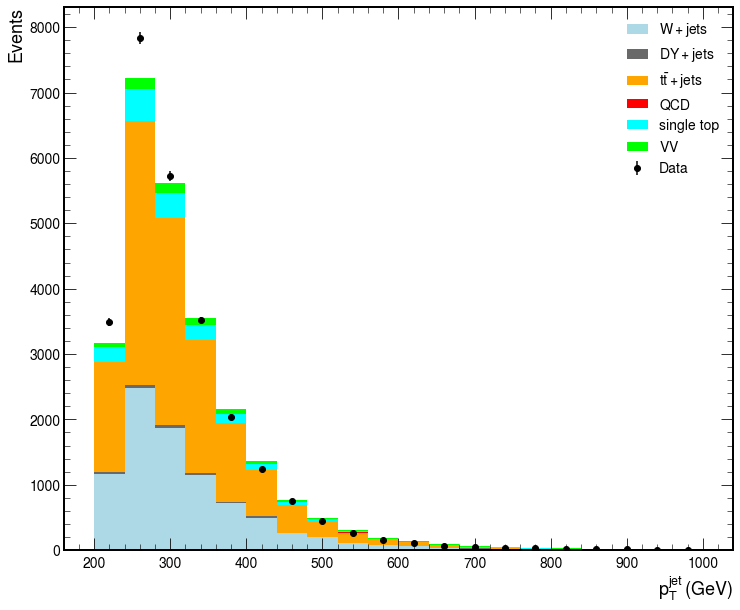

In [55]:
variation__ = "_nom"
variation_weights__ = "nom"
variable__ = "jet0_pt"
range_ = (200., 1000.) 
bins_ = 20
xlabel_ = r"$ p^{\rm{jet}}_T \,\rm{(GeV)} $"
plot_MC_data( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_, xlabel=xlabel_ )

if save_figures:
    if lepton_type == "muon":
        plt.savefig( "plots/jet_PT_muon_2018.pdf", bbox_inches='tight' )
        plt.savefig( "plots/jet_PT_muon_2018.png", bbox_inches='tight' )
    if lepton_type == "electron":
        plt.savefig( "plots/jet_PT_electron_2018.pdf", bbox_inches='tight' )
        plt.savefig( "plots/jet_PT_electron_2018.png", bbox_inches='tight' )

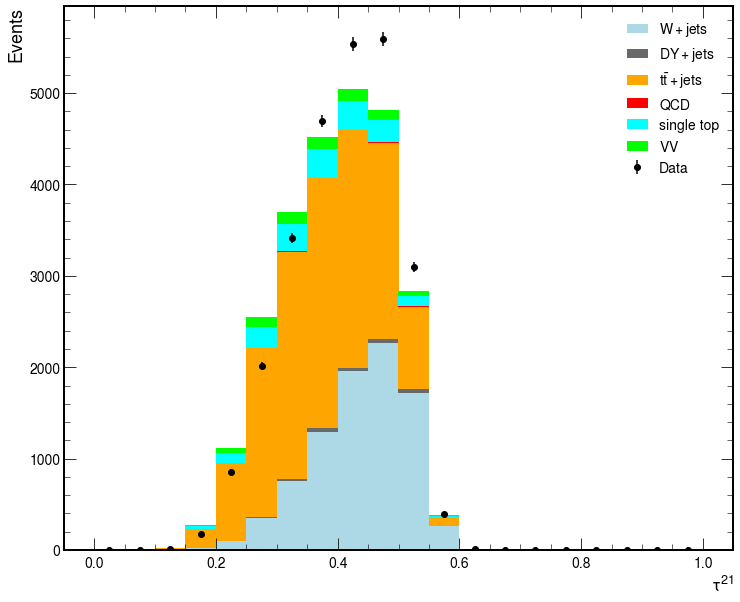

In [56]:
variation__ = "_nom"
variation_weights__ = "nom"
variable__ = "jet0_tau21"
range_ = (0., 1.) 
bins_ = 20
xlabel_ = r"$ {\tau}^{\rm{21}}} $"
plot_MC_data( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_, xlabel=xlabel_ )

if save_figures:
    if lepton_type == "muon":
        plt.savefig( "plots/jet_PT_muon_2018.pdf", bbox_inches='tight' )
        plt.savefig( "plots/jet_PT_muon_2018.png", bbox_inches='tight' )
    if lepton_type == "electron":
        plt.savefig( "plots/jet_PT_electron_2018.pdf", bbox_inches='tight' )
        plt.savefig( "plots/jet_PT_electron_2018.png", bbox_inches='tight' )

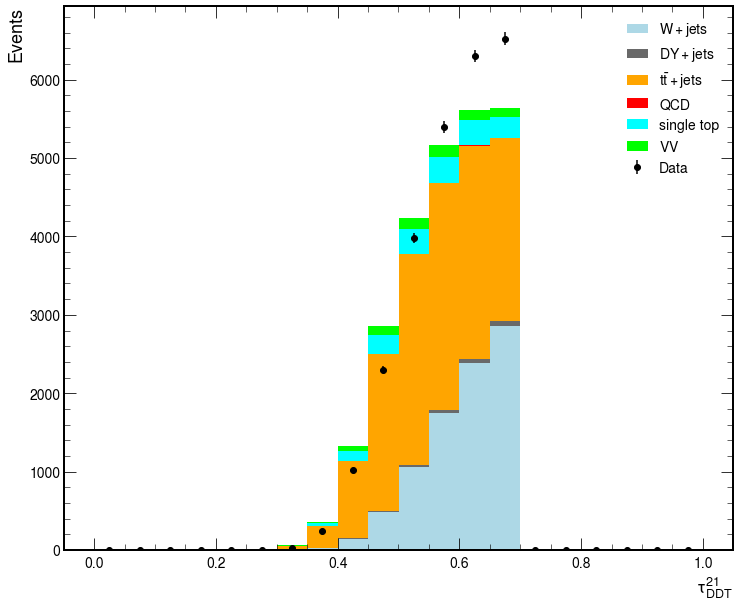

In [57]:
variation__ = "_nom"
variation_weights__ = "nom"
variable__ = "jet0_tau21_ddt"
range_ = (0., 1.) 
bins_ = 20
xlabel_ = r"$ {\tau}^{\rm{21}}_{\rm{DDT}}} $"
plot_MC_data( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_, xlabel=xlabel_ )

if save_figures:
    if lepton_type == "muon":
        plt.savefig( "plots/jet_PT_muon_2018.pdf", bbox_inches='tight' )
        plt.savefig( "plots/jet_PT_muon_2018.png", bbox_inches='tight' )
    if lepton_type == "electron":
        plt.savefig( "plots/jet_PT_electron_2018.pdf", bbox_inches='tight' )
        plt.savefig( "plots/jet_PT_electron_2018.png", bbox_inches='tight' )

In [58]:
var_str__ = {}
var_str__[ "_nom" ] = "_nom"
var_str__[ "_jes_up" ] = "_jes_up"
var_str__[ "_jes_dw" ] = "_jes_dw"
var_str__[ "_jer_up" ] = "_jer_up"
var_str__[ "_jer_dw" ] = "_jer_dw"

def get_MC_histogram_label( label, variable, variation, variation_weights, bins, range ):
       
    df_events__ = df_selected_events_MC[ label ][ variation ][ variable + var_str__[ variation ] ]
    weights_events__ = weights_events_MC[ label ][ variation_weights ][ variation ]
    weights2_events__ = ( weights_events__ ** 2 )
        
    sum_weights_bins__, bin_edges__ = np.histogram( df_events__, weights=weights_events__, bins=bins, range=range )
    sum_weights2_bins__, __ = np.histogram( df_events__, weights=weights2_events__, bins=bins, range=range )
        
    return ( sum_weights_bins__, sum_weights2_bins__, bin_edges__ )
        
def get_MC_histogram_all( variable, variation, variation_weights, bins, range ):
    
    sum_weights_bins_all_ = None
    sum_weights2_bins_all_ = None
    bin_edges_ = None
    for label__ in labels_MC_plot:
        sum_weights_bins__, sum_weights2_bins__, bin_edges__ = get_MC_histogram_label( label__, variable, variation, variation_weights, bins, range )
        if sum_weights_bins_all_ is None:
            sum_weights_bins_all_ = sum_weights_bins__
            sum_weights2_bins_all_ = sum_weights2_bins__
            bin_edges_ = bin_edges__
        else:
            sum_weights_bins_all_ = ( sum_weights_bins_all_ + sum_weights_bins__ )
            sum_weights2_bins_all_ = ( sum_weights2_bins_all_ + sum_weights2_bins__ )
        
    return ( sum_weights_bins_all_, sum_weights2_bins_all_, bin_edges_ )

def get_uncertainties_variations( variable, variations, scale_variation, bins, range ):
    
    max__ = None
    min__ = None
    
    for idx_, variation__ in enumerate( variations ):
        __variation__ = variation__ if not scale_variation else "_nom"
        __var_str__ = var_str__[ __variation__ ] if not scale_variation else "_nom"
        __variation_weights__ = variation__ if scale_variation else "nom"
        if variation__ != "_nom" and variation__ != "nom":
            print ( __variation__ )
            print ( __var_str__ )
            print ( __variation_weights__ )
                
            sum_weights__, sum_weights2__, bin_edges__ = get_MC_histogram_all( variable, __variation__, __variation_weights__, bins, range )
                
            if max__ is None: max__ = sum_weights__.copy()
            if min__ is None: min__ = sum_weights__.copy()
            msk__ = ( sum_weights__ > max__ )
            max__[ msk__ ] = sum_weights__[ msk__ ]
            msk__ = ( sum_weights__ < min__ )
            min__[ msk__ ] = sum_weights__[ msk__ ]
                
    return ( max__, min__ )    

def get_total_uncertainty( variable, bins, range ):

    lepton_type__ = lepton_type
    variable__ = variable
    bins__ = bins
    range__ = range
    
    max_variations__ = {}
    min_variations__ = {}
    
    variations__ = [ "_nom", "_jes_up", "_jes_dw" ]
    weights_max__, weights_min__ = get_uncertainties_variations( variable=variable__, variations=variations__, scale_variation=False, bins=bins__, range=range__ )
    max_variations__[ "jes" ] = weights_max__
    min_variations__[ "jes" ] = weights_min__
    
    variations__ = [ "_nom", "_jer_up", "_jer_dw" ]
    weights_max__, weights_min__ = get_uncertainties_variations( variable=variable__, variations=variations__, scale_variation=False, bins=bins__, range=range__ )
    max_variations__[ "jer" ] = weights_max__
    min_variations__[ "jer" ] = weights_min__
    
    variations_weights__ = []
    if lepton_type__ == 'muon':
        variations_weights__ = [ "nom", "sf_muon_id_up", "sf_muon_id_dw" ]
    elif lepton_type__ == 'electron':
        variations_weights__ = [ "nom", "sf_electron_id_up", "sf_electron_id_dw" ]
    weights_max__, weights_min__ = get_uncertainties_variations( variable=variable__, variations=variations_weights__, scale_variation=True, bins=bins__, range=range__ )
    
    variation_name_lepton_id__ = ""
    if lepton_type__ == 'muon': variation_name_lepton_id__ =  "sf_muon_id"
    elif lepton_type__ == 'electron': variation_name_lepton_id__ =  "sf_electron_id"
    max_variations__[ variation_name_lepton_id__ ] = weights_max__
    min_variations__[ variation_name_lepton_id__ ] = weights_min__
    
    sum_weights__, sum_weights2__, bin_edges__ = get_MC_histogram_all( variable=variable__, variation="_nom", variation_weights="nom", bins=bins__, range=range__ )
    error_bins_stat__ = np.sqrt( sum_weights2__ )
                             
    __max__ = ( sum_weights__ +
                np.sqrt(
                    ( max_variations__[ "jes" ] - sum_weights__ ) ** 2 +
                    ( max_variations__[ "jer" ] - sum_weights__ ) ** 2 +
                    ( max_variations__[ variation_name_lepton_id__ ] - sum_weights__ ) ** 2 +
                    sum_weights2__ ) )
    __min__ = ( sum_weights__ -
                np.sqrt(
                    ( sum_weights__ - min_variations__[ "jes" ] ) ** 2 +
                    ( sum_weights__ - min_variations__[ "jer" ] ) ** 2 +
                    ( sum_weights__ - min_variations__[ variation_name_lepton_id__ ] ) ** 2 +
                    sum_weights2__ ) )
                                
    return ( __max__, __min__ )
    
def plot_band_hist( ax, bin_edges, weights_min, weights_max, color, label ):
    bin_centres_ = ( bin_edges[:-1] + bin_edges[1:] ) / 2.
    
    ax.hist( bin_centres_, bottom=weights_min, weights=( weights_max - weights_min ), bins=bin_edges, color=color, label=label )


In [59]:
def plot_MC_data_stat( variable, variation, variation_weights, bins, range, xlabel ):

    variable__ = variable
    variation__ = variation
    variation_weights__ = variation_weights
    bins__ = bins
    range__ = range
    xlabel__ = xlabel

    sum_weights_bins_all_, sum_weights2_bins_all_, bin_edges_ = get_MC_histogram_all( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_ )
    error_bins_stat_ = np.sqrt( sum_weights2_bins_all_ )
    sum_weights_bins_all_min_stat_ = ( sum_weights_bins_all_ - error_bins_stat_ )
    sum_weights_bins_all_max_stat_ = ( sum_weights_bins_all_ + error_bins_stat_ )

    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.

    fig = plt.figure( figsize=(12,10) )

    plt.hist( bin_centres_, weights=sum_weights_bins_all_, bins=bin_edges_, color='darkblue', histtype='step', label=r"MC" )
    # plt.hist( bin_centres_, bottom=sum_weights_bins_all_min_stat_, weights=( sum_weights_bins_all_max_stat_ - sum_weights_bins_all_min_stat_ ), bins=bin_edges_, color='lightgray', label=r"stat" )
    plot_band_hist( plt.gca(), bin_edges=bin_edges_, weights_min=sum_weights_bins_all_min_stat_, weights_max=sum_weights_bins_all_max_stat_, color='lightgray', label=r"stat" )

    counts_bins_data_, bin_edges_ = np.histogram( df_events_data[ variable__ + var_str__[ variation__ ] ], range=range_, bins=bins_ )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )

    plt.xlabel( xlabel__, fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )
    

In [60]:
def plot_MC_data_stat_ratio(variable, variation, variation_weights, bins, range, xlabel):

    variable__ = variable
    variation__ = variation
    variation_weights__ = variation_weights
    bins__ = bins
    range__ = range
    xlabel__ = xlabel
    
    sum_weights_bins_all_, sum_weights2_bins_all_, bin_edges_ = get_MC_histogram_all( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_ )
    error_bins_stat_ = np.sqrt( sum_weights2_bins_all_ )
    sum_weights_bins_all_min_stat_ = ( sum_weights_bins_all_ - error_bins_stat_ )
    sum_weights_bins_all_max_stat_ = ( sum_weights_bins_all_ + error_bins_stat_ )

    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.

    # Create a gridspec with 2 rows and 1 column
    fig = plt.figure(figsize=(14, 16))
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])

    # Add the first plot to the first row of the gridspec
    ax0 = plt.subplot(gs[0])
    ax0.hist(bin_centres_, weights=sum_weights_bins_all_, bins=bin_edges_, color='darkblue', histtype='step', label=r"MC")
    #plot_band_hist(ax0, bin_edges=bin_edges_, weights_min=weights_min_, weights_max=weights_max_, color='slategray', label=r"total unc.")
    plot_band_hist(ax0, bin_edges=bin_edges_, weights_min=sum_weights_bins_all_min_stat_, weights_max=sum_weights_bins_all_max_stat_, color='lightgray', label=r"stat")

    counts_bins_data_, bin_edges_ = np.histogram(df_events_data[variable__ + var_str__[variation__]], range=range_, bins=bins_)
    errors_bins_data_ = np.sqrt(counts_bins_data_)
    bin_width = np.diff(bin_edges_)
    x_err = bin_width / 2.
    plt.errorbar( bin_centres_, counts_bins_data_, xerr=x_err, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )

    # Add the second plot to the second row of the gridspec
    ax1 = plt.subplot(gs[1])
    x = (bin_edges_[:-1] + bin_edges_[1:]) / 2.0
    
     # Calculate the ratio of the two histograms
    mask = sum_weights_bins_all_ > 0.
    ratio = np.zeros_like( sum_weights_bins_all_ )
    ratio[ mask ] = counts_bins_data_[ mask ] / sum_weights_bins_all_[ mask ]
    data_mc_err_ratio = np.zeros_like( sum_weights_bins_all_ ) 
    data_mc_err_ratio[ mask ] = errors_bins_data_[ mask ] / sum_weights_bins_all_[ mask ] 
                                      
    ax1.errorbar(x[ mask ], ratio[ mask ], xerr=x_err[ mask ], yerr=data_mc_err_ratio[ mask ], fmt='o', color='black', markersize=5)
    ax1.axhline(y=1, color='red', linestyle='--')
    
    # Set the labels
    ax0.set_xlabel(xlabel__, fontsize=18)
    ax0.set_ylabel("Events", fontsize=18)
    ax0.legend(loc='best', fontsize=14)
    if (variable == lepton_type+'0_eta') or (variable == lepton_type+'0_phi'): 
        ax1.set_xlim(-4.4, 4.4)
    ax1.set_xlabel(xlabel__, fontsize=18)
    ax1.set_ylabel("Data / MC", fontsize=18)

    # Adjust the spacing between the plots
    plt.subplots_adjust(hspace=0.15)

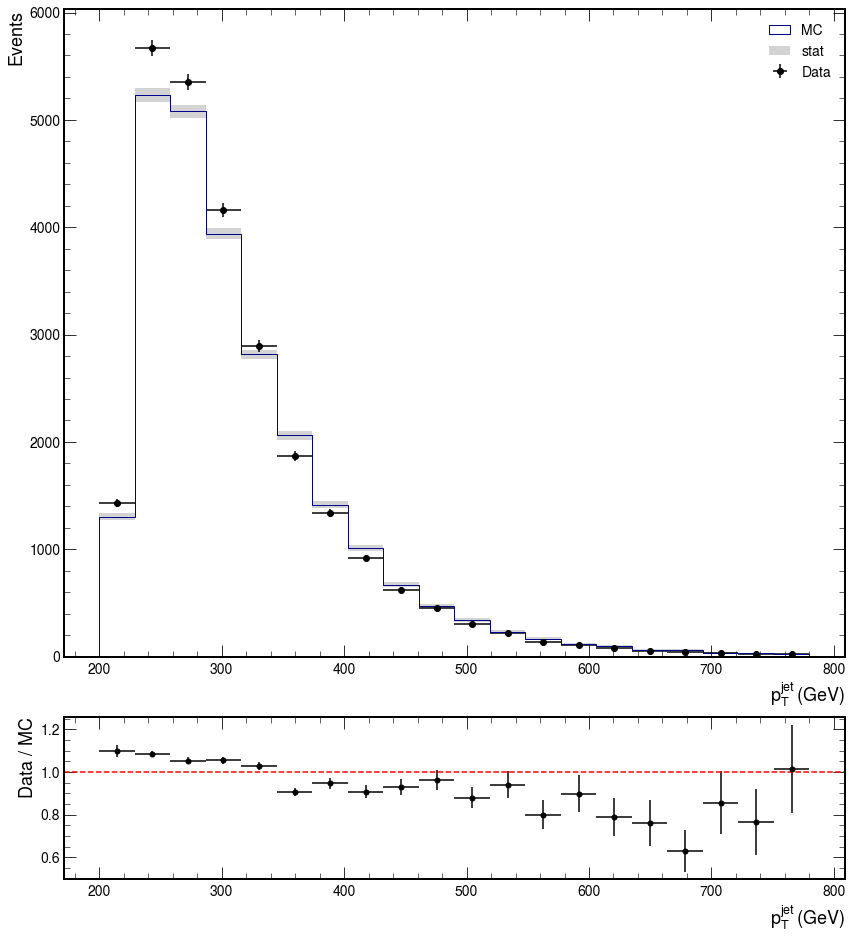

In [61]:
variation__ = "_nom"
variation_weights__ = "nom"
variable__ = "jet0_pt"
range_ = (200., 780.) 
bins_ = 20
xlabel_ = r"$ p^{\rm{jet}}_T \,\rm{(GeV)} $"
plot_MC_data_stat_ratio( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_, xlabel=xlabel_ )

In [62]:
def plot_MC_data_total_uncertainty( variable, bins, range, xlabel ):

    variable__ = variable
    bins__ = bins
    range__ = range
    xlabel__ = xlabel
    
    sum_weights_bins_all_, sum_weights2_bins_all_, bin_edges_ = get_MC_histogram_all( variable=variable__, variation="_nom", variation_weights="nom", bins=bins__, range=range__ )
    error_bins_stat_ = np.sqrt( sum_weights2_bins_all_ )
    sum_weights_bins_all_min_stat_ = ( sum_weights_bins_all_ - error_bins_stat_ )
    sum_weights_bins_all_max_stat_ = ( sum_weights_bins_all_ + error_bins_stat_ )

    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.

    weights_max_, weights_min_ = get_total_uncertainty( variable=variable__, bins=bins_, range=range_ )

    fig = plt.figure( figsize=(12,10) )

    plt.hist( bin_centres_, weights=sum_weights_bins_all_, bins=bin_edges_, color='darkblue', histtype='step', label=r"MC" )
    plot_band_hist( plt.gca(), bin_edges=bin_edges_, weights_min=weights_min_, weights_max=weights_max_, color='slategray', label=r"total unc." )
    plot_band_hist( plt.gca(), bin_edges=bin_edges_, weights_min=sum_weights_bins_all_min_stat_, weights_max=sum_weights_bins_all_max_stat_, color='lightgray', label=r"stat" )

    counts_bins_data_, bin_edges_ = np.histogram( df_events_data[ variable__ + var_str__[ variation__ ] ], range=range_, bins=bins_ )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )

    plt.xlabel( xlabel__, fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )
    

In [63]:
def plot_MC_data_total_uncertainty_ratio(variable, bins, range, xlabel):

    variable__ = variable
    bins__ = bins
    range__ = range
    xlabel__ = xlabel
    
    sum_weights_bins_all_, sum_weights2_bins_all_, bin_edges_ = get_MC_histogram_all(variable=variable__, variation="_nom", variation_weights="nom", bins=bins__, range=range__)
    error_bins_stat_ = np.sqrt(sum_weights2_bins_all_)
    sum_weights_bins_all_min_stat_ = (sum_weights_bins_all_ - error_bins_stat_)
    sum_weights_bins_all_max_stat_ = (sum_weights_bins_all_ + error_bins_stat_)

    bin_centres_ = (bin_edges_[:-1] + bin_edges_[1:]) / 2.

    weights_max_, weights_min_ = get_total_uncertainty(variable=variable__, bins=bins_, range=range_)

    # Create a gridspec with 2 rows and 1 column
    fig = plt.figure(figsize=(14, 16))
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])

    # Add the first plot to the first row of the gridspec
    ax0 = plt.subplot(gs[0])
    ax0.hist(bin_centres_, weights=sum_weights_bins_all_, bins=bin_edges_, color='darkblue', histtype='step', label=r"MC")
    plot_band_hist(ax0, bin_edges=bin_edges_, weights_min=weights_min_, weights_max=weights_max_, color='slategray', label=r"total unc.")
    plot_band_hist(ax0, bin_edges=bin_edges_, weights_min=sum_weights_bins_all_min_stat_, weights_max=sum_weights_bins_all_max_stat_, color='lightgray', label=r"stat")

    counts_bins_data_, bin_edges_ = np.histogram(df_events_data[variable__ + var_str__[variation__]], range=range_, bins=bins_)
    errors_bins_data_ = np.sqrt(counts_bins_data_)
    bin_width = np.diff(bin_edges_)
    x_err = bin_width / 2.
    plt.errorbar( bin_centres_, counts_bins_data_, xerr=x_err, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )

    # Add the second plot to the second row of the gridspec
    ax1 = plt.subplot(gs[1])
    x = (bin_edges_[:-1] + bin_edges_[1:]) / 2.0
    
     # Calculate the ratio of the two histograms
    mask = sum_weights_bins_all_ > 0.
    ratio = np.zeros_like( sum_weights_bins_all_ )
    ratio[ mask ] = counts_bins_data_[ mask ] / sum_weights_bins_all_[ mask ]
    data_mc_err_ratio = np.zeros_like( sum_weights_bins_all_ ) 
    data_mc_err_ratio[ mask ] = errors_bins_data_[ mask ] / sum_weights_bins_all_[ mask ] 
                                      
    ax1.errorbar(x[ mask ], ratio[ mask ], xerr=x_err[ mask ], yerr=data_mc_err_ratio[ mask ], fmt='o', color='black', markersize=5)
    ax1.axhline(y=1, color='red', linestyle='--')
    
    # Set the labels
    ax0.set_xlabel(xlabel__, fontsize=18)
    ax0.set_ylabel("Events", fontsize=18)
    ax0.legend(loc='best', fontsize=14)
    if (variable == "jet0_eta") or (variable == "jet0_phi"): 
        ax1.set_xlim(-4.4, 4.4)
    ax1.set_xlabel(xlabel__, fontsize=18)
    ax1.set_ylabel("Data / MC", fontsize=18)

    # Adjust the spacing between the plots
    plt.subplots_adjust(hspace=0.15)

_jes_up
_jes_up
nom
_jes_dw
_jes_dw
nom
_jer_up
_jer_up
nom
_jer_dw
_jer_dw
nom
_nom
_nom
sf_electron_id_up
_nom
_nom
sf_electron_id_dw


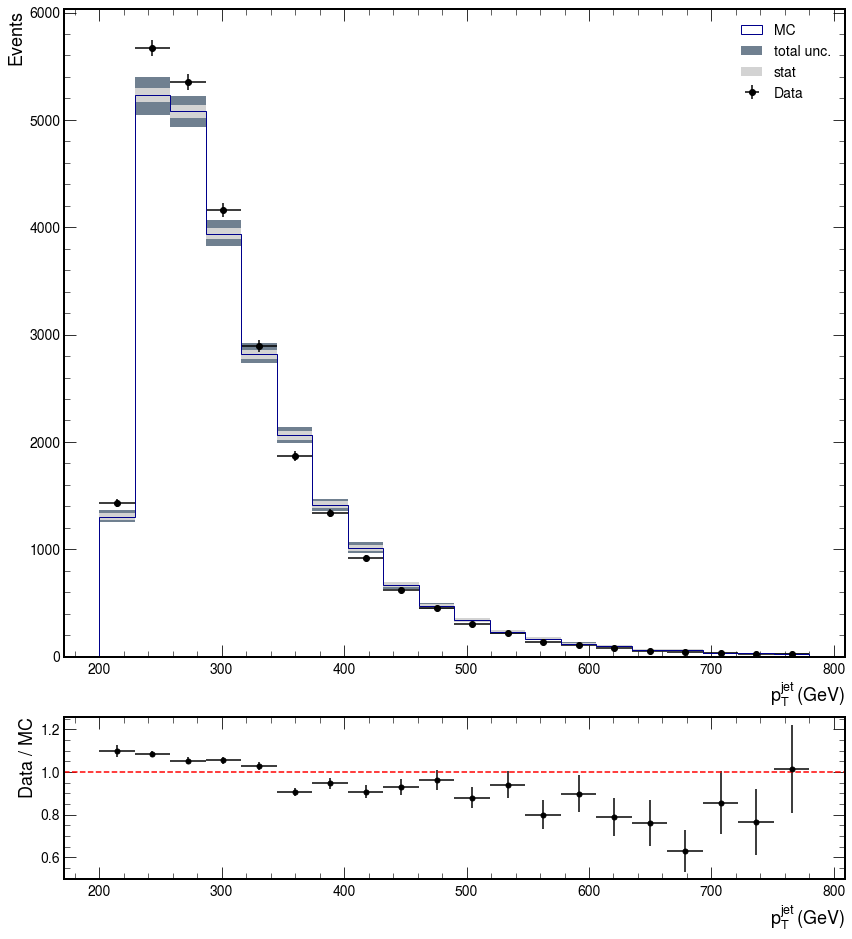

In [64]:
##adição minha -12/01stat
variation__ = "_nom"
variation_weights__ = "nom"
##
variable__ = "jet0_pt"
range_ = (200., 780.) 
bins_ = 20
xlabel_ = r"$ p^{\rm{jet}}_T \,\rm{(GeV)} $"
plot_MC_data_total_uncertainty_ratio( variable=variable__, bins=bins_, range=range_, xlabel=xlabel_ )
##plot_MC_data_stat( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_, xlabel=xlabel_ )

if save_figures:
    if lepton_type == "muon":
        plt.savefig( "plots/jet_PT_muon_2018_with_unc.pdf", bbox_inches='tight' )
        plt.savefig( "plots/jet_PT_muon_2018_with_unc.png", bbox_inches='tight' )
    if lepton_type == "electron":
        plt.savefig( "plots/jet_PT_electron_2018_with_unc.pdf", bbox_inches='tight' )
        plt.savefig( "plots/jet_PT_electron_2018_with_unc.png", bbox_inches='tight' )

_jes_up
_jes_up
nom
_jes_dw
_jes_dw
nom
_jer_up
_jer_up
nom
_jer_dw
_jer_dw
nom
_nom
_nom
sf_electron_id_up
_nom
_nom
sf_electron_id_dw


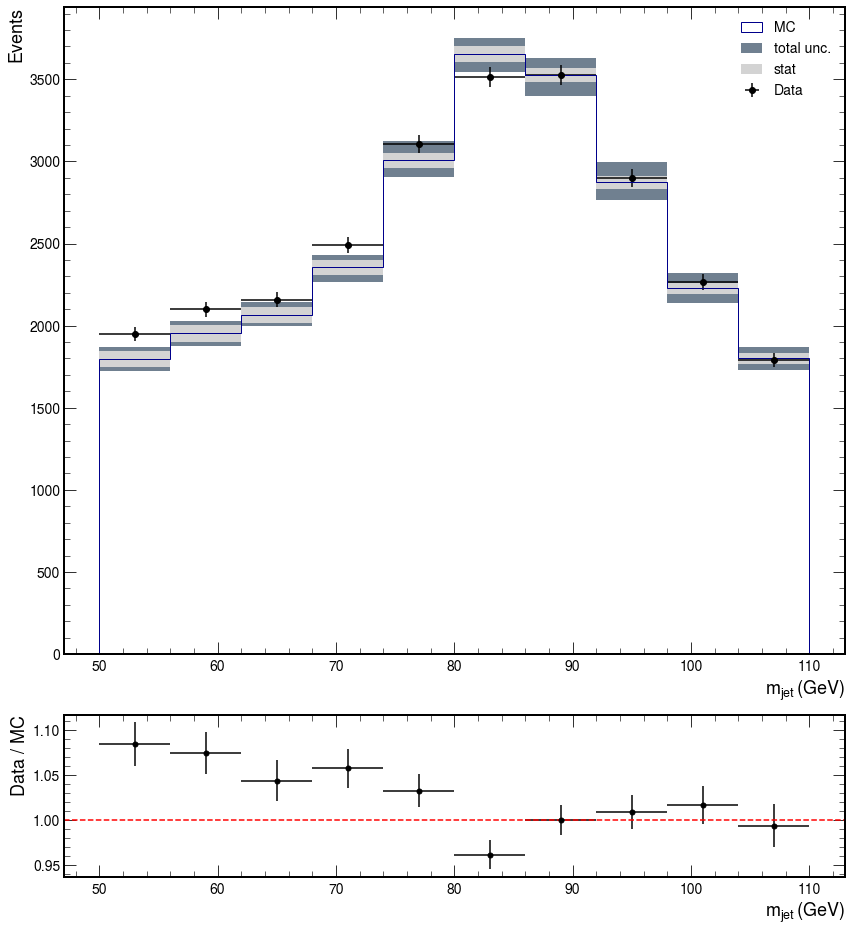

In [65]:
variable__ = "jet0_corrmass"
range_ = (50., 110.) 
bins_ = 10
xlabel_ = r"$ m_{\rm{jet}} \,\rm{(GeV)} $"
plot_MC_data_total_uncertainty_ratio( variable=variable__, bins=bins_, range=range_, xlabel=xlabel_ )
#plot_MC_data_stat( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_, xlabel=xlabel_ )

if save_figures:
    if lepton_type == "muon":
        plt.savefig( "plots/jet_mass_muon_2018_with_unc.pdf", bbox_inches='tight' )
        plt.savefig( "plots/jet_mass_muon_2018_with_unc.png", bbox_inches='tight' )
    if lepton_type == "electron":
        plt.savefig( "plots/jet_mass_electron_2018_with_unc.pdf", bbox_inches='tight' )
        plt.savefig( "plots/jet_mass_electron_2018_with_unc.png", bbox_inches='tight' )

_jes_up
_jes_up
nom
_jes_dw
_jes_dw
nom
_jer_up
_jer_up
nom
_jer_dw
_jer_dw
nom
_nom
_nom
sf_electron_id_up
_nom
_nom
sf_electron_id_dw


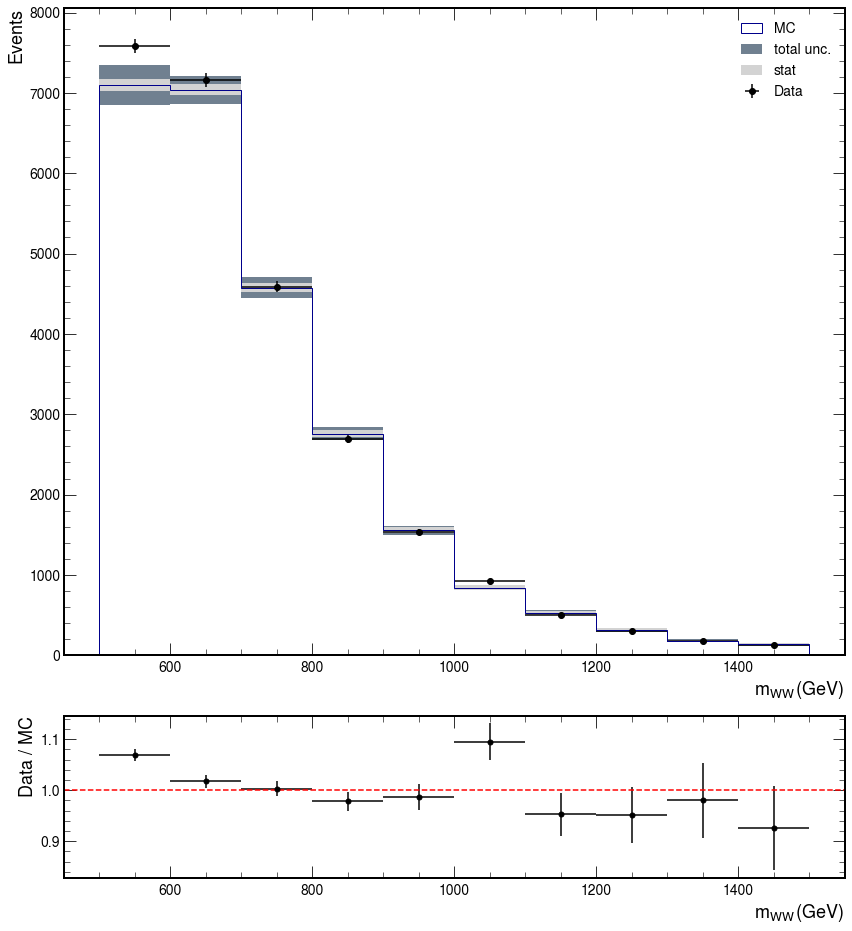

In [66]:
variable__ = "MWW"
range_ = (500., 1500.) 
bins_ = 10
xlabel_ = r"$ m_{WW} \,\rm{(GeV)} $"
plot_MC_data_total_uncertainty_ratio( variable=variable__, bins=bins_, range=range_, xlabel=xlabel_ )
#plot_MC_data_stat( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_, xlabel=xlabel_ )

if save_figures:
    if lepton_type == "muon":
        plt.savefig( "plots/WW_mass_muon_2018_with_unc.pdf", bbox_inches='tight' )
        plt.savefig( "plots/WW_mass_muon_2018_with_unc.png", bbox_inches='tight' )
    if lepton_type == "electron":
        plt.savefig( "plots/WW_mass_electron_2018_with_unc.pdf", bbox_inches='tight' )
        plt.savefig( "plots/WW_mass_electron_2018_with_unc.png", bbox_inches='tight' )

_jes_up
_jes_up
nom
_jes_dw
_jes_dw
nom
_jer_up
_jer_up
nom
_jer_dw
_jer_dw
nom
_nom
_nom
sf_electron_id_up
_nom
_nom
sf_electron_id_dw


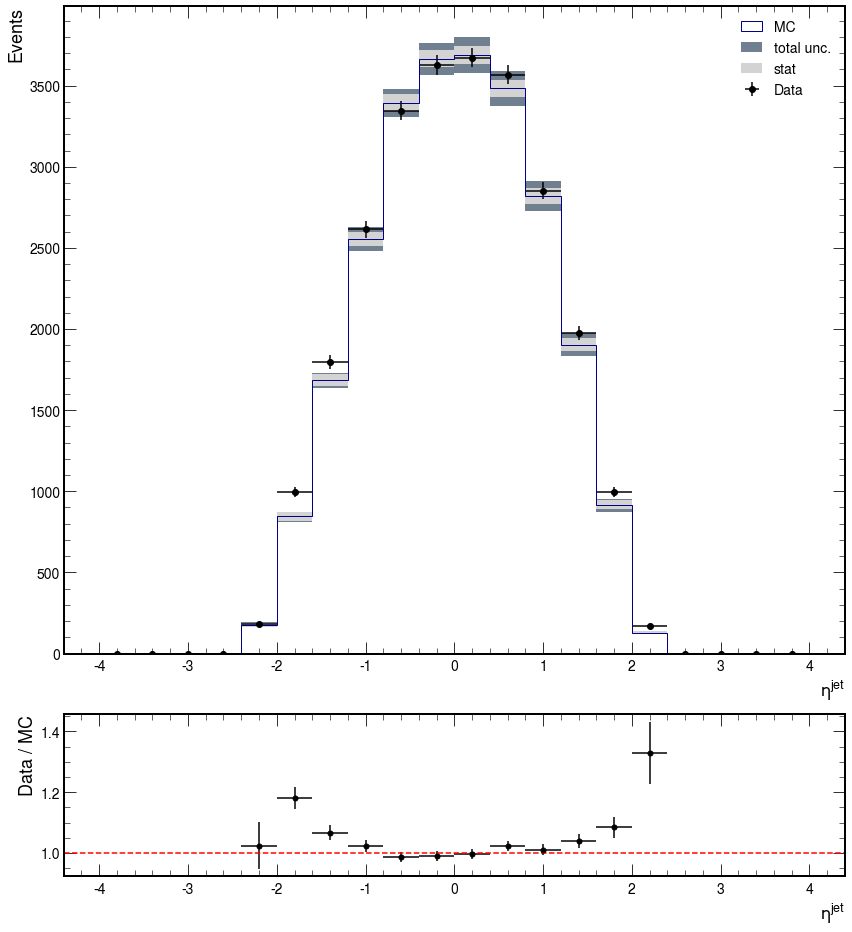

In [67]:
variable__ = "jet0_eta"
range_ = (-4., 4.) 
bins_ = 20
xlabel_ = r"$ {\eta}^{\rm{jet}} \ $"
plot_MC_data_total_uncertainty_ratio( variable=variable__, bins=bins_, range=range_, xlabel=xlabel_ )
#plot_MC_data_stat( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_, xlabel=xlabel_ )

if save_figures:
    if lepton_type == "muon":
        plt.savefig( "plots/jet_eta_muon_2018_with_unc.pdf", bbox_inches='tight' )
        plt.savefig( "plots/jet_eta_muon_2018_with_unc.png", bbox_inches='tight' )
    if lepton_type == "electron":
        plt.savefig( "plots/jet_eta_electron_2018_with_unc.pdf", bbox_inches='tight' )
        plt.savefig( "plots/jet_eta_electron_2018_with_unc.png", bbox_inches='tight' )

_jes_up
_jes_up
nom
_jes_dw
_jes_dw
nom
_jer_up
_jer_up
nom
_jer_dw
_jer_dw
nom
_nom
_nom
sf_electron_id_up
_nom
_nom
sf_electron_id_dw


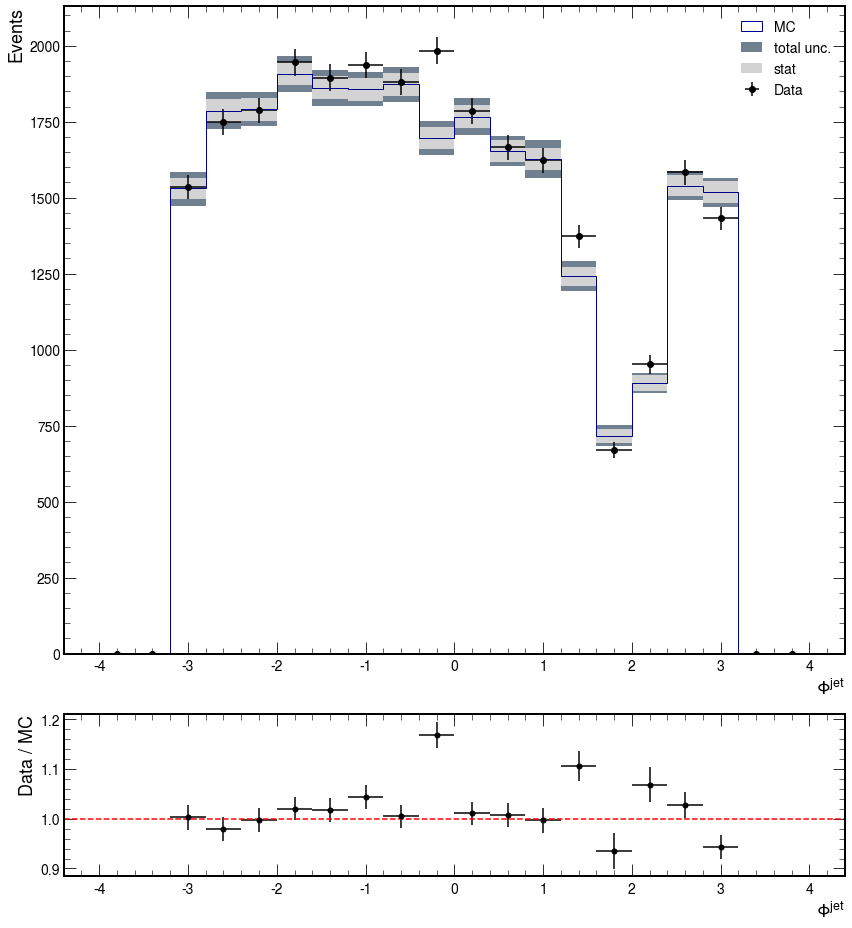

In [68]:
variable__ = "jet0_phi"
range_ = (-4., 4.) 
bins_ = 20
xlabel_ = r"$ {\Phi}^{\rm{jet}} \ $"
plot_MC_data_total_uncertainty_ratio( variable=variable__, bins=bins_, range=range_, xlabel=xlabel_ )
#plot_MC_data_stat( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_, xlabel=xlabel_ )

if save_figures:
    if lepton_type == "muon":
        plt.savefig( "plots/jet_phi_muon_2018_with_unc.pdf", bbox_inches='tight' )
        plt.savefig( "plots/jet_phi_muon_2018_with_unc.png", bbox_inches='tight' )
    if lepton_type == "electron":
        plt.savefig( "plots/jet_phi_electron_2018_with_unc.pdf", bbox_inches='tight' )
        plt.savefig( "plots/jet_phi_electron_2018_with_unc.png", bbox_inches='tight' )

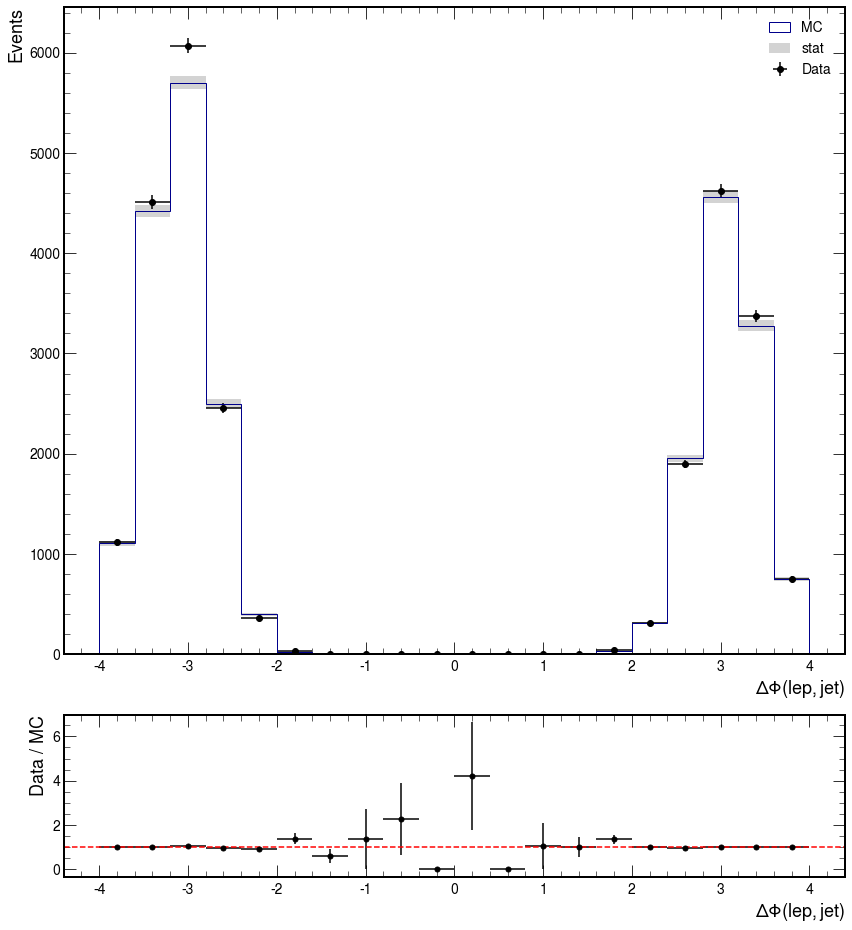

In [69]:
variable__ = "deltaPhi_jet_lep"
range_ = (-4., 4.) 
bins_ = 20
xlabel_ = r"$ {\Delta\Phi}({\rm{lep,jet}}) \ $"
#plot_MC_data_total_uncertainty_ratio( variable=variable__, bins=bins_, range=range_, xlabel=xlabel_ )
plot_MC_data_stat_ratio( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_, xlabel=xlabel_ )

if save_figures:
    if lepton_type == "muon":
        plt.savefig( "plots/jet_phi_muon_2018_with_unc.pdf", bbox_inches='tight' )
        plt.savefig( "plots/jet_phi_muon_2018_with_unc.png", bbox_inches='tight' )
    if lepton_type == "electron":
        plt.savefig( "plots/jet_phi_electron_2018_with_unc.pdf", bbox_inches='tight' )
        plt.savefig( "plots/jet_phi_electron_2018_with_unc.png", bbox_inches='tight' )

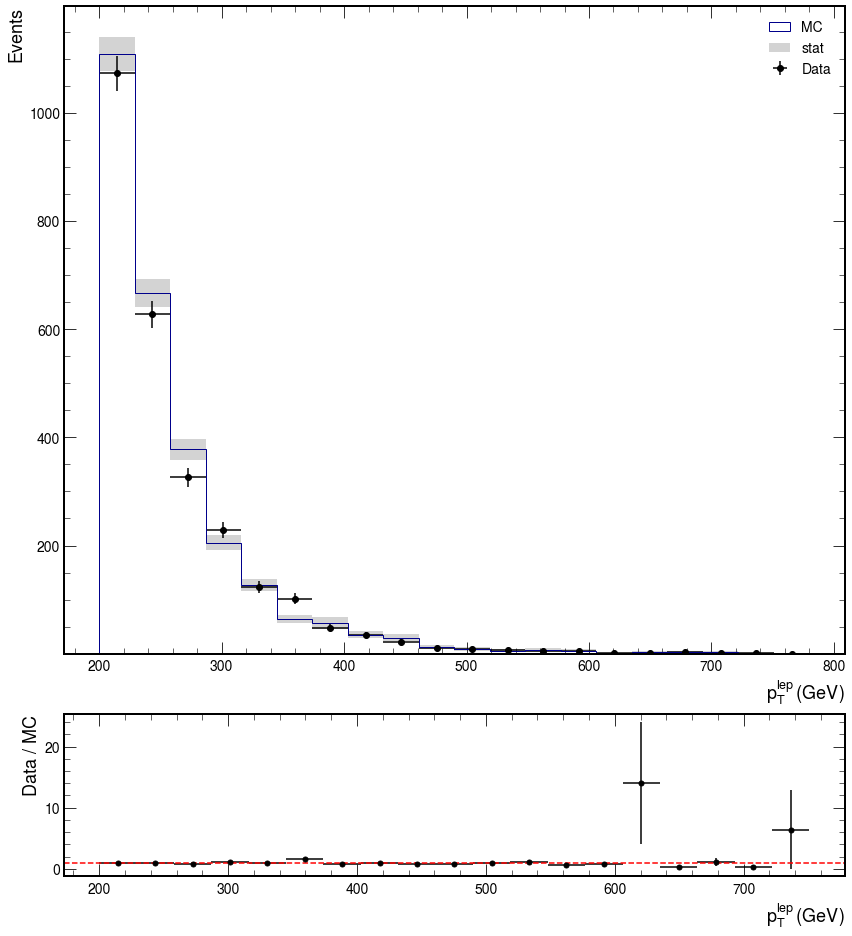

In [70]:
variable__ = lepton_type+'0_pt'
range_ = (200., 780.) 
bins_ = 20
xlabel_ = r"$ p^{\rm{lep}}_T \,\rm{(GeV)} $"
#plot_MC_data_total_uncertainty( variable=variable__, bins=bins_, range=range_, xlabel=xlabel_ )
plot_MC_data_stat_ratio( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_, xlabel=xlabel_ )

if save_figures:
    if lepton_type == "muon":
        plt.savefig( "plots/muon_PT_2018_with_stat.pdf", bbox_inches='tight' )
        plt.savefig( "plots/muon_PT_2018_with_stat.png", bbox_inches='tight' )
    if lepton_type == "electron":
        plt.savefig( "plots/electron_PT_2018_with_stat.pdf", bbox_inches='tight' )
        plt.savefig( "plots/electron_PT_2018_with_stat.png", bbox_inches='tight' )

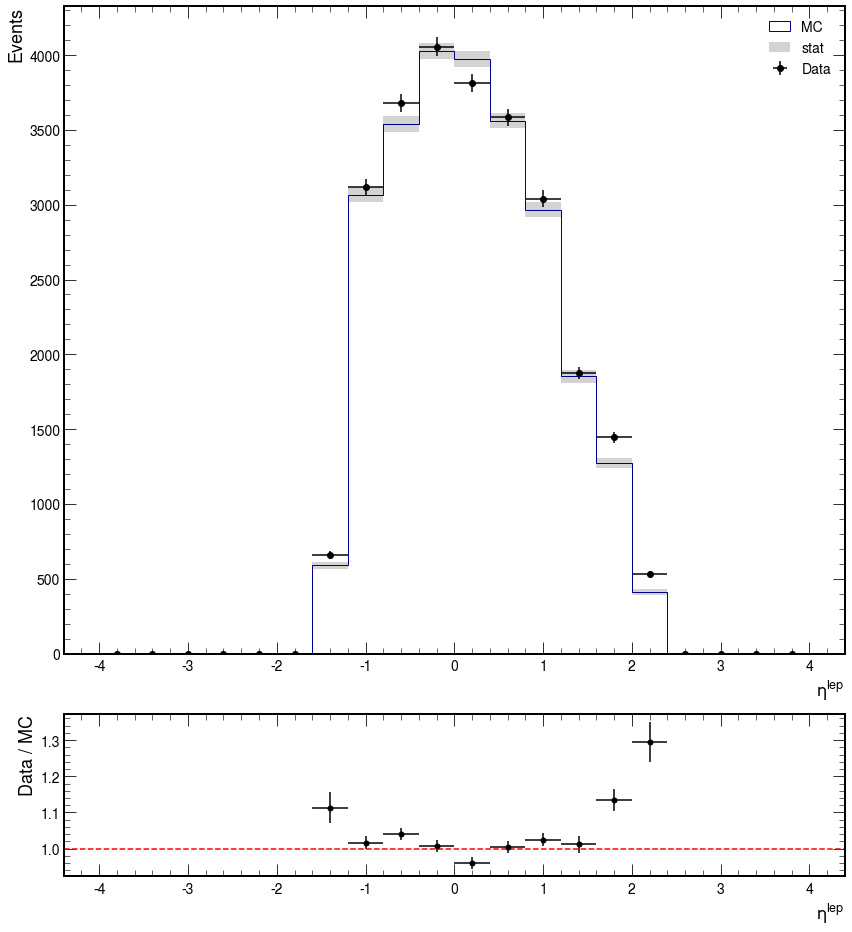

In [71]:
variable__ = lepton_type+'0_eta'
range_ = (-4., 4.) 
bins_ = 20
xlabel_ = r"$ {\eta}^{\rm{lep}} \ $"
#plot_MC_data_total_uncertainty( variable=variable__, bins=bins_, range=range_, xlabel=xlabel_ )
plot_MC_data_stat_ratio( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_, xlabel=xlabel_ )

if save_figures:
    if lepton_type == "muon":
        plt.savefig( "plots/muon_eta_2018_with_stat.pdf", bbox_inches='tight' )
        plt.savefig( "plots/muon_eta_2018_with_stat.png", bbox_inches='tight' )
    if lepton_type == "electron":
        plt.savefig( "plots/electron_eta_2018_with_stat.pdf", bbox_inches='tight' )
        plt.savefig( "plots/electron_eta_2018_with_stat.png", bbox_inches='tight' )

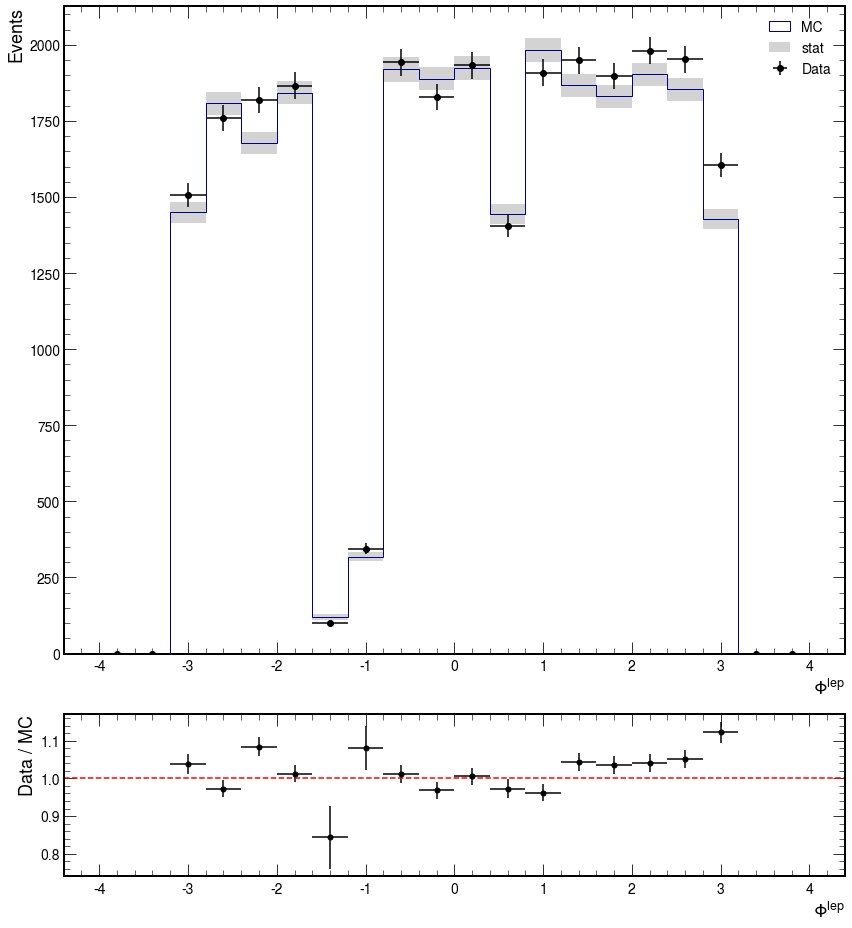

In [72]:
variable__ = lepton_type+'0_phi'
range_ = (-4., 4.) 
bins_ = 20
xlabel_ = r"$ {\Phi}^{\rm{lep}} \ $"
#plot_MC_data_total_uncertainty( variable=variable__, bins=bins_, range=range_, xlabel=xlabel_ )
plot_MC_data_stat_ratio( variable=variable__, variation=variation__, variation_weights=variation_weights__, bins=bins_, range=range_, xlabel=xlabel_ )

if save_figures:
    if lepton_type == "muon":
        plt.savefig( "plots/muon_phi_2018_with_stat.pdf", bbox_inches='tight' )
        plt.savefig( "plots/muon_phi_2018_with_stat.png", bbox_inches='tight' )
    if lepton_type == "electron":
        plt.savefig( "plots/electron_phi_2018_with_stat.pdf", bbox_inches='tight' )
        plt.savefig( "plots/electron_phi_2018_with_stat.png", bbox_inches='tight' )